# Identify fake job postings!
Your friend is on the job market. However, they keep wasting time applying for fraudulent job postings. They have asked you to use your data skills to filter out fake postings and save them effort.

They have mentioned that job postings are abundant, so they would prefer that your solution risks filtering out real posts if it decreases the number of fraudulent posts they apply to.

You have access to a dataset consisting of approximately 18'000 job postings, containing both real and fake jobs.

_The original source of the data can be found [here](https://www.kaggle.com/datasets/whenamancodes/real-or-fake-jobs), and the data dictionary can be found in the `data_dictionary.ipynb` file in your file browser!_

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import unicodedata
from nltk.stem import WordNetLemmatizer

#Set aspects of the visual theme for all matplotlib and seaborn plots.
#This function changes the global defaults for all plots using the matplotlib rcParams system. The themeing is decomposed into several distinct sets of parameter values.
sns.set_theme()

RANDOM_SEED = 42


# Dataset

## About Dataset
[Real or Fake] : Fake Job Description Prediction

This dataset contains 18K job descriptions out of which about 800 are fake. 
The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

## Data Dictionary

| Column                | Description 
| ---                   | --- 
| job_id                | Unique Job ID
| title                 | The title of the job ad entry
| location              | Geographical location of the job ad
| department            | Corporate department (e.g. sales)
| salary_range			| Indicative salary range (e.g. $50,000-$60,000)
| company_profile		| A brief company description
| description			| The details description of the job ad
| requirements			| Enlisted requirements for the job opening
| benefits				| Enlisted offered benefits by the employer
| telecommuting			| True for telecommuting positions
| hascompanylogo		| True if company logo is present
| has_questions			| True if screening questions are present
| employment_type		| Full-type, Part-time, Contract, etc
| required_experience	| Executive, Entry level, Intern, etc
| required_education	| Doctorate, Master’s Degree, Bachelor, etc
| industry				| Automotive, IT, Health care, Real estate, etc
| function				| Consulting, Engineering, Research, Sales etc
| fraudulent			| target - Classification attribute

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("fake_job_postings.csv")
print("(Rows, columns) :", df.shape)
df.head()

(Rows, columns) : (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# EDA 

Exploratory data analysis.

## Data validation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

## Columns

We will ignore job id

In [5]:
TEXT_COLS = ["title","company_profile","description", "requirements", "benefits"]
NUM_COLS = ["telecommuting", "has_company_logo", "has_questions"]
CAT_COLS = ["location","salary_range", "employment_type" , "required_experience","required_education", "function","industry"]
TARGET_COL = ["fraudulent"]


### Filter Columns

**Filter selected columns**, ignore some columns with too much missing data ['department','salary_range','benefits' ], also ignore job_id:

In [6]:
def filter_columns(df):
    COLUMNS= TEXT_COLS + NUM_COLS + CAT_COLS + TARGET_COL
    return df[COLUMNS]

df = filter_columns(df)
df.columns


Index(['title', 'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'location',
       'salary_range', 'employment_type', 'required_experience',
       'required_education', 'function', 'industry', 'fraudulent'],
      dtype='object')

Counting **missing data** and the proportion in each column:

In [7]:
df[df["fraudulent"]==1].isnull().sum()

title                    0
company_profile        587
description              1
requirements           154
benefits               364
telecommuting            0
has_company_logo         0
has_questions            0
location                19
salary_range           643
employment_type        241
required_experience    435
required_education     451
function               337
industry               275
fraudulent               0
dtype: int64

In [8]:
df.isnull().agg(["sum", "mean"]).T

,sum,mean
title,0.0,0.000000
company_profile,3308.0,0.185011
description,1.0,0.000056
requirements,2695.0,0.150727
benefits,7210.0,0.403244
telecommuting,0.0,0.000000
has_company_logo,0.0,0.000000
has_questions,0.0,0.000000
location,346.0,0.019351
salary_range,15012.0,0.839597


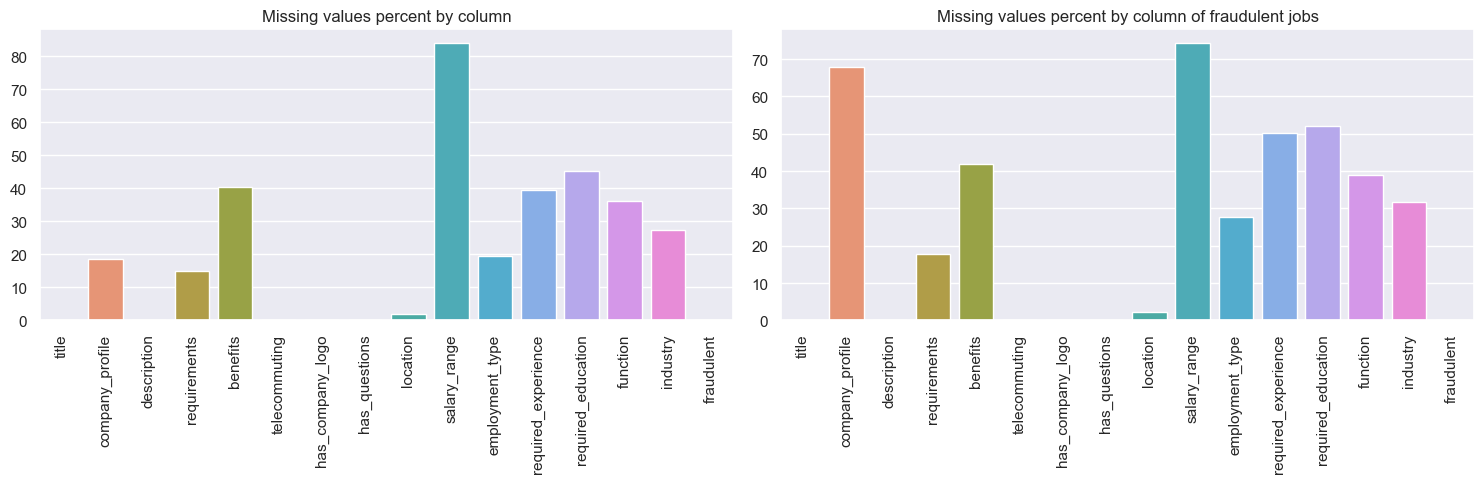

In [9]:
fig, (ax0, ax1) = plt.subplots(ncols=2, layout="tight", figsize=(15,5))
ax= sns.barplot(x=df.columns, y=df.isnull().sum()/df.shape[0]*100, ax=ax0 )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Missing values percent by column")

ax= sns.barplot(x=df.columns, y=df[df["fraudulent"]==1].isnull().sum()/df[df["fraudulent"]==1].shape[0]*100, ax=ax1 )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Missing values percent by column of fraudulent jobs");

Capturing the notion of **one observation**:

In [10]:
dict(df.iloc[0])

{'title': 'Marketing Intern',
 'company_profile': "We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City.",
 'description': 'Food52, a fast-growing, James Beard Award-wi

Checking **category columns**, knowing the count of unique values and some values in specific:

In [11]:
df[CAT_COLS].nunique()

location               3105
salary_range            874
employment_type           5
required_experience       7
required_education       13
function                 37
industry                131
dtype: int64

In [12]:
df["location"].value_counts().sample(10, random_state=0)

RO, IS, Iasi                  1
GB, LND, Notting Hill        10
US, , chicago                 1
US, NY, NYC & Garden City     3
GB, LND, Camden, London       4
GR, , Thessaloniki            1
GB, BRD,                      1
GB, , Ossett                  3
US, MD, Crofton               1
US, IL, Libertyville          8
Name: location, dtype: int64

In [13]:
df["salary_range"].value_counts().sample(20, random_state=7)

20800-22880             1
10000-120000            1
14436-28000             1
25000-32000             1
60-90                   1
8-Sep                   1
800000000-1200000000    1
65000-90000             2
15400-19600             1
15500-50000             1
9-Dec                   1
15000-20000             5
65000-110000            1
20000-260000            1
8000-9000               1
29120-37440             1
33000-39000             1
26000-31000             1
110000-125000           2
36000-42000             6
Name: salary_range, dtype: int64

In [14]:
df["employment_type"].value_counts()

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

In [15]:
df["required_experience"].value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

In [16]:
df["required_education"].value_counts()

Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

In [17]:
df["function"].value_counts()

Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    38
Supply C

In [18]:
df["industry"].value_counts().sort_index().head(10)

Accounting                        159
Airlines/Aviation                  63
Alternative Dispute Resolution      1
Animation                           5
Apparel & Fashion                  97
Architecture & Planning            10
Automotive                        120
Aviation & Aerospace               24
Banking                            84
Biotechnology                      38
Name: industry, dtype: int64

In [19]:
df["industry"].value_counts()

Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
                                       ... 
Shipbuilding                              1
Sporting Goods                            1
Museums and Institutions                  1
Wine and Spirits                          1
Ranching                                  1
Name: industry, Length: 131, dtype: int64

Analyzing **text columns**:

In [20]:
# Checking lenghts of text columns 
for col in TEXT_COLS:
    print("Column:", col, end=" ")
    print("min_len:", df[col].str.strip().str.len().min(), end=" ")
    print("max_len:", df[col].str.strip().str.len().max(), end="")
    print("\n")


Column: title min_len: 3 max_len: 142

Column: company_profile min_len: 9.0 max_len: 6178.0

Column: description min_len: 0.0 max_len: 14881.0

Column: requirements min_len: 0.0 max_len: 10864.0

Column: benefits min_len: 0.0 max_len: 4427.0



In [21]:
df["title"].value_counts().head()

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: title, dtype: int64

In [22]:
df[df["company_profile"].str.strip().str.len()<40]["company_profile"].value_counts()

Hiring made easy for Digital Jobs    7
About Us.                            1
Great BenefitsCompetitive Pay        1
Lasertag Adventure - Profile         1
Super awesome games and apps         1
Somos uma empresa de TI foda!        1
Check us out                         1
The Online Talent Booking Agency.    1
Name: company_profile, dtype: int64

In [23]:
df[df["description"].str.strip().str.len()<9]["description"].value_counts()

#NAME?                                          8
                                                1
Name: description, dtype: int64

In [24]:
print(dict(df[df["description"].fillna("").str.contains("\xa0")]["description"].head(1)))


{1: "Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa090 Seconds, the worlds Cloud Video Production Service -\xa0http:

In [25]:
print(dict(df[df["description"].fillna("").str.contains(r"#.*_.*#", regex=True)]["description"].head(1)))

{1: "Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa090 Seconds, the worlds Cloud Video Production Service -\xa0http:

In [26]:
df[df["requirements"].str.strip().str.len()<10]["requirements"].value_counts()


#NAME?       36
.             2
---           2
TBD           2
16-21         1
None          1
GED           1
x             1
Doctors,      1
About Us      1
              1
Java/J2EE     1
See above     1
Cv/Resume     1
              1
Test          1
STATA, R      1
.NETC#        1
Name: requirements, dtype: int64

In [27]:
df[df["requirements"].str.strip().str.len()<10]["requirements"].value_counts().keys()

Index(['#NAME?', '.', '---', 'TBD', '16-21', 'None', 'GED', 'x', 'Doctors, ',
       'About Us', '  ', 'Java/J2EE', 'See above', 'Cv/Resume', ' ', 'Test',
       'STATA, R', '.NETC#'],
      dtype='object')

**Observations:**

**TEXT COLUMNS**
1. `title` - no missing data and looks good
2. `company_profile` - 18.5% percent of missing data in all dataset, when filtering only the fraudulent jobs this goes to near 70%, we can make the hypothesis that a job with no company profile have more chance of being fraudulent
3. `description` - there are many observations with the value "#NAME?", will be replaced with empty string
4. `requirements` - there are many observations with no meaningful text,['#NAME?', '.', '---', 'TBD', 'Test', '16-21', 'x', 'None'] will be replaced by empty string
5. Strings will be stripped and any missing data will be replaced by an empty string
6. text columns contains text likes this #URL_86fd830a95a64e2b30ceed829e63fd384c289e4f01e3c93608b42a84f6e662dd#, with the possible values being [URL_, PHONE_, EMAIL_] and encrypted text, this should be replaced by empty string, this text does not seems useful
7. Text contain unicode chars, convert text to ascii
8. Text contains words that are not separated, ex: pressureExcellent, when a lower capital letter is followed by capitalized letter then will be inserted one whitespace between them

**NUMERIC COLUMNS**
1. `telecommuting` - no missing data, value is either `0` or `1`
2. `has_company_logo` - no missing data, value is either `0` or `1`
3. `has_questions` - no missing data, value is either `0` or `1`

**CATEGORY COLUMNS**
1. `location` - 2% missing data, comma separated values, first value is country code, second is state/city code, more values after the second comma are detailed descriptions of state/city/location, we will keep the country code and state/city code in separate columns and drop this column
2. `employment_type` - 19.4 % missing data, 5 types ['Full-time', 'Contract', 'Part-time', 'Temporary', 'Other']
3. `required_experience` - almost 40% missing data, 7 types ['Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive']
4. `required_education` - 45.3% missing data, 13 types ["Bachelor's Degree", 'High School or equivalent', 'Unspecified', "Master's Degree", 'Associate Degree', 'Certification', 'Some College Coursework Completed', 'Professional', 'Vocational', 'Some High School Coursework', 'Doctorate', 'Vocational - HS Diploma', 'Vocational - Degree']
5. `function` - 36.1% missing data, 37 different types, "Information Technology" the most represented and "Science" the least one
6. `industry` - 27.4% missing data, 131 types "Information Technology and Services", "Computer Software" and "Internet" in the top 3 common
7. `salary_range` - more than 80% missing data, from the available data we can see that some data does not corresponds to a correct range for example `60-90` and `8-Sep` values, with so much missing data and with incorrect data we will drop this column. As suggestion is a necessary to review the way data is storage in this column.
8. Any missing data will be replaced by the word "MISSING"




In [28]:
#drop salary_range column
CAT_COLS.remove("salary_range")
df = df.drop(columns=["salary_range"])


## Cleaning data


### TEXT COLUMNS

In [29]:
import re

def split_word(matchobj):
    """
    This function takes a match object and returns a string with a space
    inserted between the first and second characters of the matched string.
    
    :param matchobj: A match object.
    :return: A string with a space inserted between the first and second
             characters of the matched string
    """
    return  matchobj.group(0)[0] + " " +matchobj.group(0)[1]



df[TEXT_COLS] = df[TEXT_COLS].fillna("")

for col in TEXT_COLS:    
    #encode/decode with the 'ignore' option, it will remove non-ascii characters:
    df[col] = df[col].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'replace').decode())    
    # strip text
    df[col] = df[col].str.strip()
    #when a lower capital letter is followed by capitalized letter then will be inserted one whitespace between them
    df[col] = df[col].apply(lambda val: re.sub(r'([a-z][A-Z])', split_word, val))

In [30]:
# cleaning description
filter = df["description"].isin(['#NAME?'])
df.loc[filter, "description"] = ""

# cleaning requirements
filter = df["requirements"].str.strip().isin(['#NAME?', '.', '---', 'TBD', 'Test', '16-21', 'x', 'None'])
df.loc[filter, "requirements"] = ""

# replace encoded strings 
df[TEXT_COLS] = df[TEXT_COLS].replace(r"(#(EMAIL_|PHONE_|URL_)([^#])*#)|((EMAIL_|PHONE_|URL_)([^#])*##)", " " , regex=True)

#replace underscore with whitespace
for col in TEXT_COLS:  
    df[col] = df[col].str.replace("_"," ")


### CATEGORY COLUMNS

In [31]:
df[CAT_COLS] = df[CAT_COLS].fillna("MISSING")

## Feature engineering

### `location`

Split text by comma and keep only the 2 first values that represents the country code and city/state

In [32]:
df[["country", "state"]]=df["location"].str.split(",", expand=True, n=2)[[0,1]]
df[["country", "state"]]

df["country"] = df["country"].str.strip().replace("", "MISSING")
df["state"] = df["state"].str.strip().fillna("MISSING").replace("", "MISSING")


In [33]:
df["country"].value_counts()

US    10656
GB     2384
GR      940
CA      457
DE      383
      ...  
SI        1
CO        1
SD        1
UG        1
KH        1
Name: country, Length: 91, dtype: int64

### text columns to length columns

In [34]:
LEN_COLS = []
for col in TEXT_COLS:
    new_col = col+"_len"
    df[new_col] = df[col].str.len()
    LEN_COLS.append(new_col)
    NUM_COLS.append(new_col)


## Filter columns

In [35]:
CAT_COLS.remove("location")
CAT_COLS = CAT_COLS + ["country","state"]


df = filter_columns(df)

In [36]:
df.columns

Index(['title', 'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'title_len',
       'company_profile_len', 'description_len', 'requirements_len',
       'benefits_len', 'employment_type', 'required_experience',
       'required_education', 'function', 'industry', 'country', 'state',
       'fraudulent'],
      dtype='object')

In [37]:
df.isnull().sum()

title                  0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
title_len              0
company_profile_len    0
description_len        0
requirements_len       0
benefits_len           0
employment_type        0
required_experience    0
required_education     0
function               0
industry               0
country                0
state                  0
fraudulent             0
dtype: int64

## Describing numeric columns

Starting with a simple pandas describe for numeric columns:

In [38]:
df.describe()

,telecommuting,has_company_logo,has_questions,title_len,company_profile_len,description_len,requirements_len,benefits_len,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,28.429754,607.254027,1195.626902,587.400895,204.940045,0.048434
std,0.202631,0.403492,0.499945,13.869966,558.460959,886.097778,609.431979,329.356012,0.214688
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,19.000000,137.000000,592.000000,146.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,25.000000,552.000000,1003.000000,465.000000,44.000000,0.000000
75%,0.000000,1.000000,1.000000,35.000000,870.000000,1570.000000,817.000000,290.250000,0.000000
max,1.000000,1.000000,1.000000,142.000000,6184.000000,14881.000000,10795.000000,4460.000000,1.000000


## Target: `fraudulent`

Total: 17880
Non Fraudulent: 17014
Fraudulent: 866
Fraudulent percent: 4.84 %


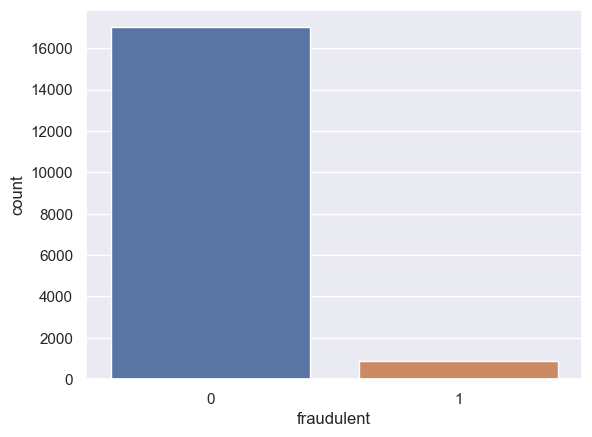

In [39]:
print("Total:",df.shape[0])
print("Non Fraudulent:", (-df["fraudulent"]+1).sum())
print("Fraudulent:", df["fraudulent"].sum())
print("Fraudulent percent:", np.round(df["fraudulent"].mean()*100,2), "%")
sns.countplot(data=df, x="fraudulent");

We have an unbalanced classification problem, only 5% of our dataset are fraudulent job posts!

## Profile Report

To quickly get a feel for the distribution of data, we can use [`pandas-profiling`](https://github.com/pandas-profiling/pandas-profiling).

Note that the output is long and scrollable, so be sure to scroll through.

Some quick observations from this report are:
* 2.8% of rows are duplicated, effect of removing the `job_id` feature
* `function` is highly correlated with `employment_type`, `required_experience` and `required_education`, also have 36.1% missing data, so we will drop this column
* `required_experience` is highly correlated with `required_education`, we will choose to drop the `required_education` column, since there is more missing data in this column
* Our label `fraudulent` is not too strongly related with any other single feature, the feature that shows more correlation is the `has_company_logo`
* `company_profile_len` is highly correlated with `has_company_logo`, so we will drop this column
* `title_len`. `description_len`, `requirements_len` are right skewed, we will deal with this in when processing the data 


In [40]:
# profile = ProfileReport(df)

# profile.to_notebook_iframe()



Drop the correlated features:

In [41]:
df = df.drop(columns=["function", "required_education", "company_profile_len"])
CAT_COLS.remove("function")
CAT_COLS.remove("required_education")
NUM_COLS.remove("company_profile_len")
LEN_COLS.remove("company_profile_len")

## Country and State
Most of the job posts are from the United States (US). Malaysia(MY) and Bahrain (BH) have the highest rate of fraudulent job posts, with more than 50% chance of a job post being fraudulent.

country
US          6.85
AU         18.69
GB          0.96
MISSING     5.49
MY         57.14
CA          2.63
QA         28.57
BH         55.56
IN          1.45
PL          3.95
Name: fraudulent, dtype: float64


[Text(0.5, 1.0, 'Top 10 - percentage of fraudulent job posts by country code'),
 (0.0, 100.0)]

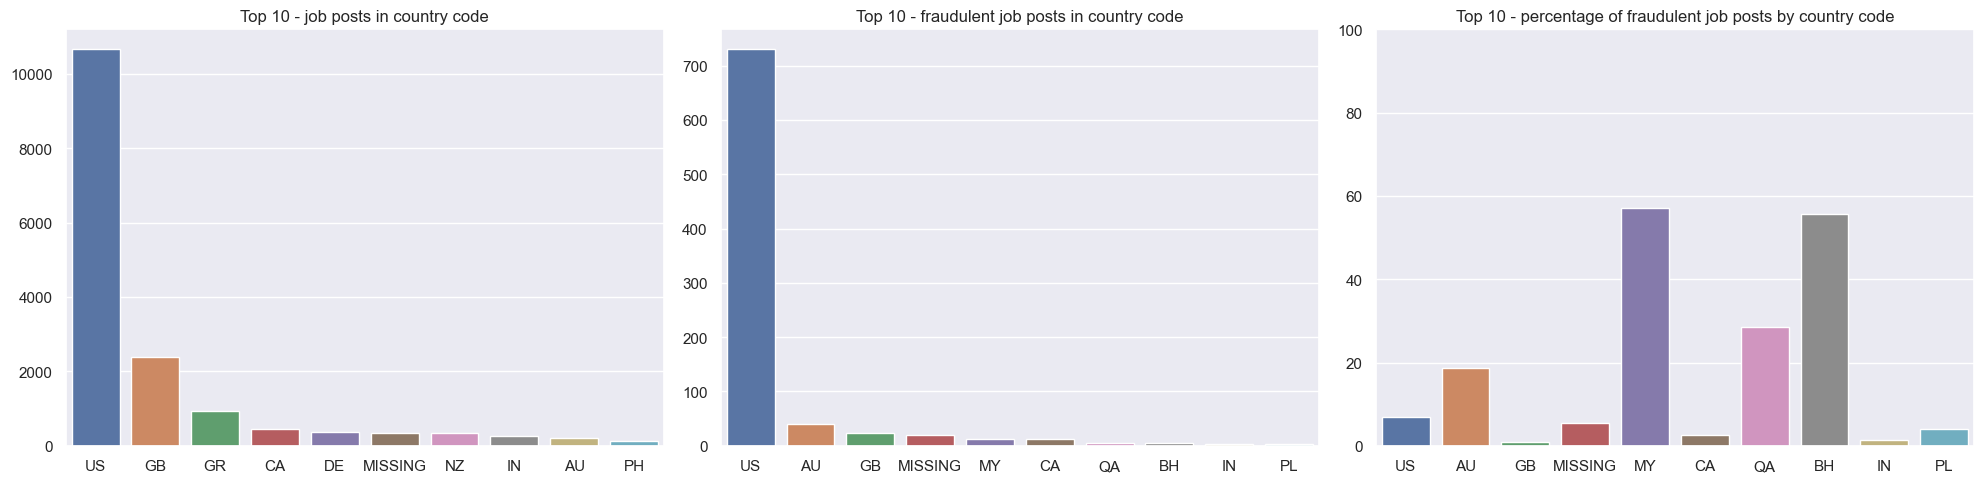

In [42]:
from pandas.api.types import CategoricalDtype

fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(20,5), layout="tight" )



df_ana = df[["country","state", "fraudulent"]].copy()


countries_top10 = df_ana["country"].value_counts().head(10)
countries_top10_fraudulent = df_ana[df_ana["fraudulent"]==1]["country"].value_counts().head(10)
#to set order by when calculating percentage for each country
cat_country_order = CategoricalDtype( df_ana[df_ana["fraudulent"]==1]["country"].value_counts().index, ordered=True)
df_ana["country"] = df_ana["country"].astype(cat_country_order)


countries_top10_fraudulent_perc = df_ana.sort_values("country").groupby("country")["fraudulent"].mean().head(10)*100

print(countries_top10_fraudulent_perc.round(2))

sns.barplot(x=countries_top10.index, y=countries_top10.values  , ax = ax0).set(title="Top 10 - job posts in country code")
sns.barplot(x=countries_top10_fraudulent.index, y=countries_top10_fraudulent.values  , ax = ax1).set(title="Top 10 - fraudulent job posts in country code")
sns.barplot(x=countries_top10_fraudulent_perc.index.to_list(), y=countries_top10_fraudulent_perc.values  , ax = ax2).set(title="Top 10 - percentage of fraudulent job posts by country code", ylim=(0,100))


Looking into only US job post, California (CA) have the most quantity of job posts. Maryland (MD) have the highest rate of fake job posts.

state
TX         15.59
CA          6.97
NY          5.40
MISSING     7.53
MD         32.71
FL          7.23
GA          8.40
IL          4.25
OH          4.84
NC          7.56
Name: fraudulent, dtype: float64


[Text(0.5, 1.0, 'Top 10 - percentage fraudulent job posts by state code of US country'),
 (0.0, 100.0)]

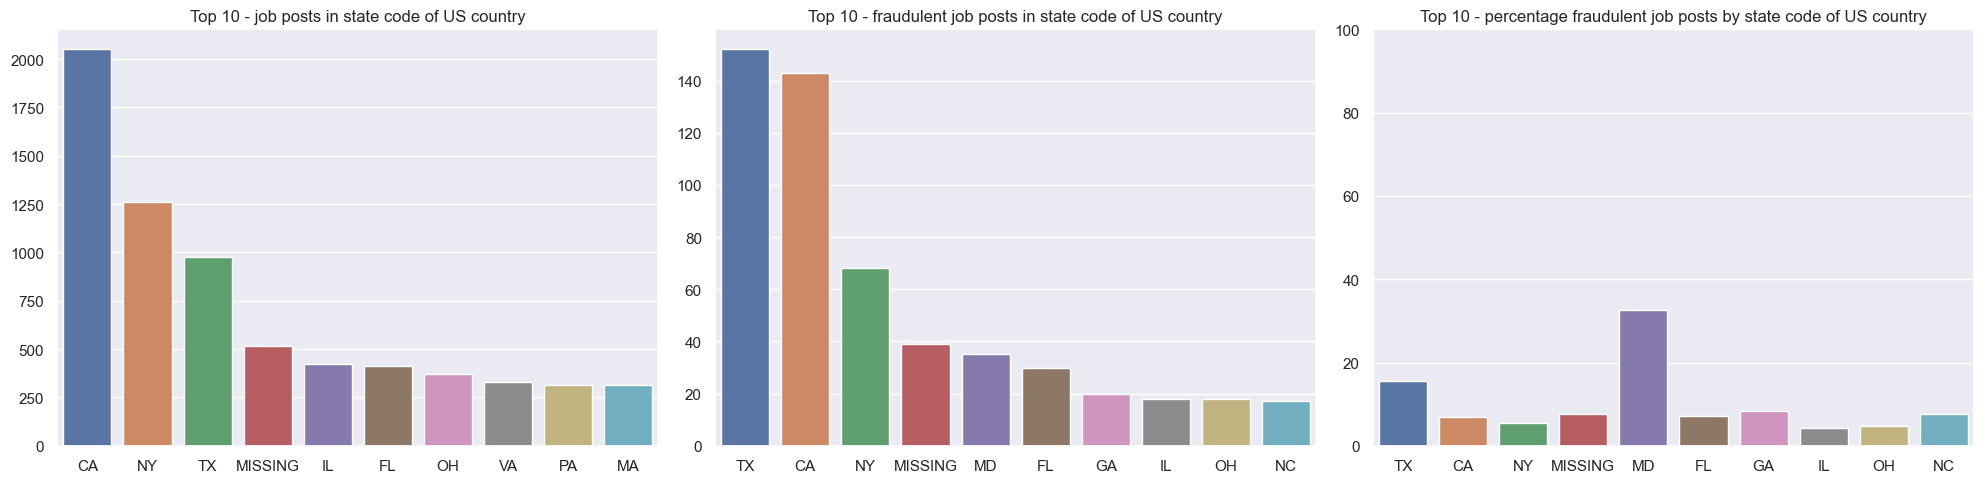

In [43]:
fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(20,5), layout="tight" )
df_country_us = df[df["country"]=="US"]


us_states_top10 = df_country_us["state"].value_counts().head(10)
us_states_top10_fraudulent = df_country_us[df_country_us["fraudulent"]==1]["state"].value_counts().head(10)
#to set order by when calculating percentage for each country
cat_state_order = CategoricalDtype( df_country_us[df_country_us["fraudulent"]==1]["state"].value_counts().index, ordered=True)
df_country_us["state"] = df_country_us["state"].astype(cat_state_order)
us_states_top10_fraudulent_perc = df_country_us.sort_values("state").groupby("state")["fraudulent"].mean().head(10)*100

print(us_states_top10_fraudulent_perc.round(2))

sns.barplot(x=us_states_top10.index, y=us_states_top10.values  , ax = ax0).set(title="Top 10 - job posts in state code of US country")
sns.barplot(x=us_states_top10_fraudulent.index, y=us_states_top10_fraudulent.values  , ax = ax1).set(title="Top 10 - fraudulent job posts in state code of US country")
sns.barplot(x=us_states_top10_fraudulent_perc.index.to_list(), y=us_states_top10_fraudulent_perc.values  , ax = ax2).set(title="Top 10 - percentage fraudulent job posts by state code of US country", ylim=(0,100))

## Numeric columns

Starting with a simple pandas describe for numeric columns:


In [44]:
df.describe()

,telecommuting,has_company_logo,has_questions,title_len,description_len,requirements_len,benefits_len,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,28.429754,1195.626902,587.400895,204.940045,0.048434
std,0.202631,0.403492,0.499945,13.869966,886.097778,609.431979,329.356012,0.214688
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,19.000000,592.000000,146.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,25.000000,1003.000000,465.000000,44.000000,0.000000
75%,0.000000,1.000000,1.000000,35.000000,1570.000000,817.000000,290.250000,0.000000
max,1.000000,1.000000,1.000000,142.000000,14881.000000,10795.000000,4460.000000,1.000000


Lets check numeric columns to see how they impact on job post being fraudulent.

using this symbols:
- P(T) - probability of Telecommuting 
- P(L) - probability of has_company_logo
- P(Q) - probability of has_questions
- P(F) - probability of fraudulent

We get this probabilities:
- $P(F \mid T)$ = 0.083442 $P(F \mid \overline{T})$ = 0.046865
- $P(F \mid L)$ = 0.019902 $P(F \mid \overline{L})$ = 0.15929
- $P(F \mid Q)$ = 0.028435 $P(F \mid \overline{Q})$ = 0.067782

Observations:
- Posts that have telecommuting (remote job), have a probability almost 2x greater to be fraudulent than not telecommuting.
- Not having the company logo have almost 7x the probability of being fraudulent than having logo.
- If screening questions are present, has_questions is true, the job post have almost 1/3 the probability to be fraudulent than not having screening questions.




telecommuting         0         1       All
fraudulent                                 
0              0.953135  0.916558  0.951566
1              0.046865  0.083442  0.048434
has_company_logo        0         1       All
fraudulent                                   
0                 0.84071  0.980098  0.951566
1                 0.15929  0.019902  0.048434
has_questions         0         1       All
fraudulent                                 
0              0.932218  0.971565  0.951566
1              0.067782  0.028435  0.048434


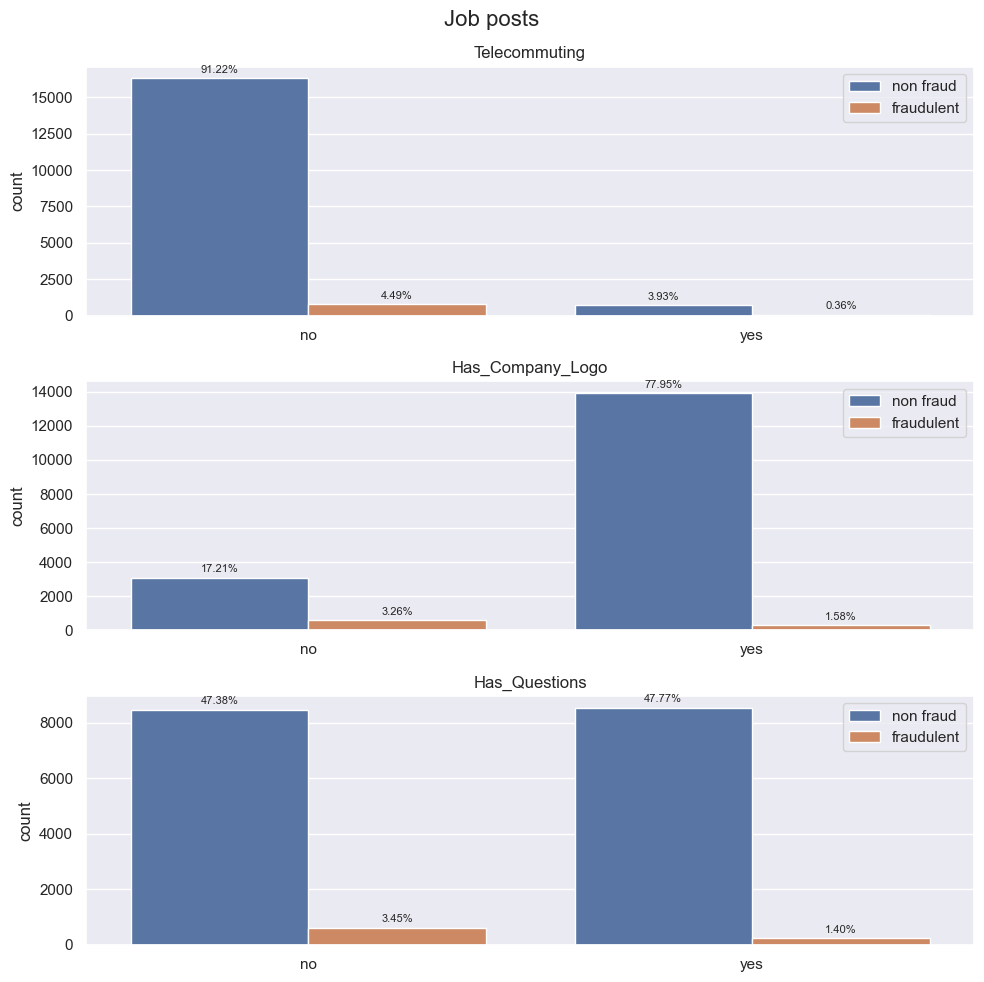

In [45]:
cols_inspect = ['telecommuting', 'has_company_logo', 'has_questions']

fig, axs = plt.subplots(nrows=len(cols_inspect),figsize=(10,10), layout="tight")
fig.suptitle('Job posts', fontsize=16)

def annotate_percent(ax, n):
    for a in ax.patches:
        val = np.round(a.get_height()/n*100,decimals=2)
        ax.annotate('{:.2f}%'.format(val) ,
            (a.get_x()+a.get_width()/2, a.get_height()),
            ha='center',
            va='center',
            xytext=(0, 6),
            textcoords='offset points',
            fontsize = 8,
          )

for i, col in enumerate(cols_inspect):         
    ax = axs[i]       
    # print("col:",df.groupby(col)["fraudulent"].mean())
    sns.countplot(data=df, x = col, hue="fraudulent", ax=ax).set(title=str.title(col))      
    annotate_percent(ax, df.shape[0])    
    ax.legend(['non fraud', 'fraudulent'])
    ax.set_xticks(ax.get_xticks(),["no", "yes"])
    ax.set_xlabel("")
    # creates a crosstab with the conditional probabilities
    print(pd.crosstab( df["fraudulent"],df[col], normalize='columns', margins=True))
    



Inspecting the kernel density of title, description and requirements separated by fraudulent and non fraudulent we can observe that longer titles tends to be fraudulent, smaller descriptions and requirements tend to be fraudulent job posts.

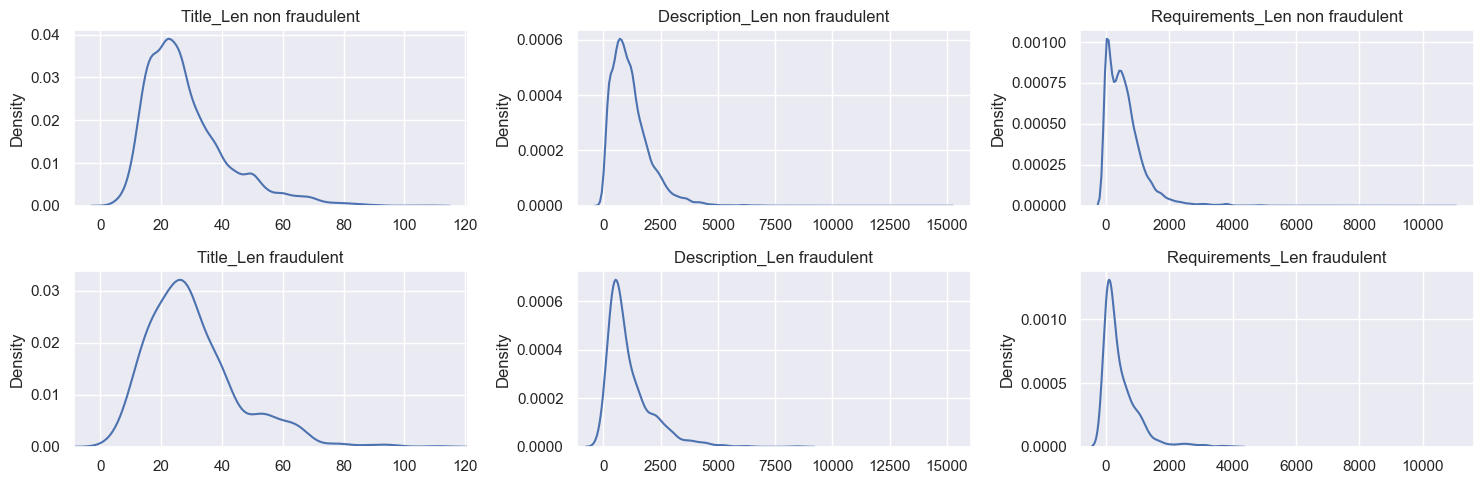

In [46]:
cols_inspect = ['title_len', 'description_len', 'requirements_len']

fig , axs = plt.subplots(nrows=2, ncols=len(cols_inspect), layout="tight", figsize=(15,5))

for i, col in enumerate(cols_inspect):
    ax = axs[0][i]
    
    sns.kdeplot(df[df["fraudulent"]==0], x=col, ax =ax)
    ticks = ax.get_xticks()
    xlim = ax.get_xlim()
    ax.set(title=str.title(col)+" non fraudulent" )
    ax.set_xlabel("")
    
    ax = axs[1][i]
    
    sns.kdeplot(df[df["fraudulent"]==1], x=col, ax =ax)
    ax.set_xticks(ticks)
    ax.set_xlim(xlim)
    ax.set(title=str.title(col)+" fraudulent" )
    ax.set_xlabel("")


# Processing the data

We will split data into training and test sets

In [47]:
train_df, test_df = train_test_split(df, stratify=df["fraudulent"], random_state = RANDOM_SEED) #using stratify because the imbalance of the target feature

Here, we try to scale and transform the len features to make them smoother, less skewed, and more appropriate for modeling.

`PowerTransformer` attempts to make the data more like a normal distribution, which should soften the impact of extreme outliers and make the distributions smoother.

`MinMaxScaler` is used as a first step to make sure the numbers are in a reasonable range, as `PowerTransformer` can fail on very large numbers.

In [48]:
pipeline = make_pipeline(MinMaxScaler(), PowerTransformer())

train_df_norm = pd.DataFrame(pipeline.fit_transform(train_df[LEN_COLS]), columns=LEN_COLS)
train_df_norm = train_df_norm.combine_first(train_df.reset_index()) # Add the other columns back

test_df_norm = pd.DataFrame(pipeline.fit_transform(test_df[LEN_COLS]), columns=LEN_COLS)
test_df_norm = test_df_norm.combine_first(test_df.reset_index()) # Add the other columns back


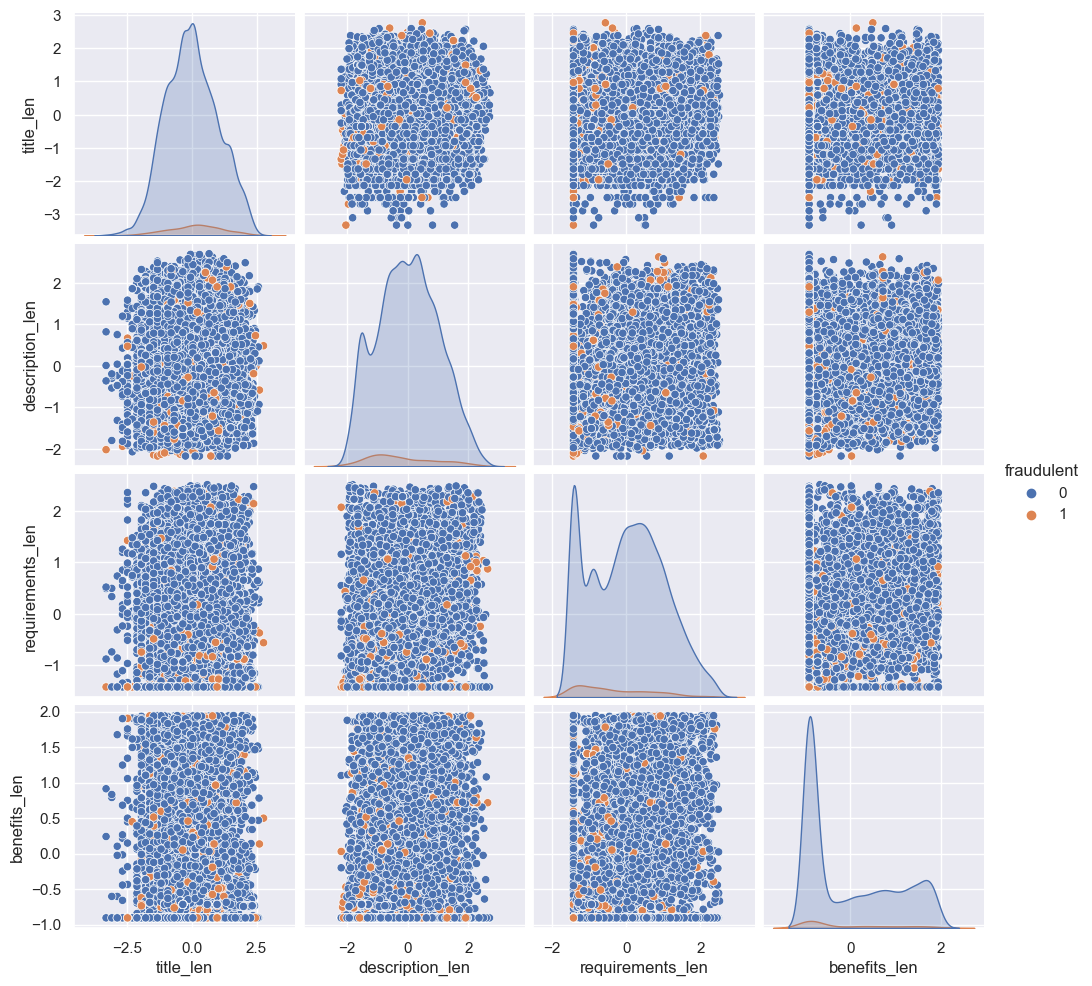

In [49]:
sns.pairplot(train_df_norm[LEN_COLS+TARGET_COL], hue="fraudulent") 

# Model training

For the time being, we'll only use the numeric columns for this model. The textual columns require specialized preprocessing before they can be used as input to a model.


In [50]:
X_train = train_df_norm[NUM_COLS]
y_train = train_df_norm[TARGET_COL]

X_test = test_df_norm[NUM_COLS]
y_test = test_df_norm[TARGET_COL]

## Baseline - DummyClassifier

Now, we'll fit a DummyClassifier, this makes predictions that ignore the input features.

This classifier serves as a simple baseline to compare against other more complex classifiers.

In [51]:
clf_baseline = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
clf_baseline.fit(X_train, y_train)


DummyClassifier(random_state=42, strategy='most_frequent')

### Evaluation and Metric choose

Since we know that the classes are very imbalanced (only about 4.84% of the questions labeled as fraudulent), as we can see using the dummy model that have 50% of probability of a guess to be right is giving a ~95% accuracy, we'll avoid using the accuracy metric. Instead, we'll take a look at the precision-recall curve, which can tell us more useful information.


In [52]:
y_pred = clf_baseline.predict(X_test)
print("Accuracy:",np.round( metrics.accuracy_score(y_test, y_pred),4), " = portion of non fraudulent job posts:", np.round(1-np.mean(y_test.values),4))

Accuracy: 0.9517  = portion of non fraudulent job posts: 0.9517



Having  the follow confusion matrix:

|               | Positive Prediction | Negative Prediction |
|---------------|-------------------- |---------------------|
|Positive Class | True Positive (TP)  | False Negative (FN) |
|Negative Class | False Positive (FP) | True Negative (TN)  |



One thing that we want to avoid is to get in-touch with people that posted a fake job post, as stated in the beginning of this notebook "they would prefer that your solution risks filtering out real posts if it decreases the number of fraudulent posts they apply to", so we need to maximize how well our model identifies fake job posts reducing the False Negatives predictions, to deal with that we will use the Recall metric. In other hand we don't want our model to have a bad quality predicting fake job posts, having to much not fraudulent job posts classified as fake, we will use the Precision metric to evaluate this.
- Recall = Sensitivity = TPR = $\frac{TP}{TP + FN}$
- Precision = $\frac{TP}{TP + FP}$

How to choose Precision and Recall?
Almost always, in practice, we have to choose between a high precision or a high recall. It’s usually impossible to have both. 
We can achieve either of the two by various means:
- Assigning a higher weighting to the examples of a specific class (the SVM algorithm accepts weightings of classes as input)
- Tuning hyperparameters to maximize precision or recall on the validation set.
- Varying the decision threshold for algorithms that return probabilities of classes; for instance, if we use logistic regression or decision tree, to increase recall (at the cost of a lower precision), we can decide that the prediction will be positive only if the probability returned by the model is higher than 0.2. We will use this approach.

Another metric we will use to evaluate how well the model does predictions it will be the F1-score. F1-score is the geometric average of precision and recall. F1-score relies between 0 and 1, with 1 being the best value.

By default machine learning models uses a threshold equal to 0.5, that means if a prediction probability is higher or equal than 0.5 then is class "1" in the other way if the probability is lower than 0.5 then is class "0". To choose the optimal threshold we will use Precision-Recall curve to get the maximum F1-score and get the equivalent threshold.
Tuning or shifting the decision threshold in order to accommodate the broader requirements of the classification problem is generally referred to as "threshold-moving" "threshold-tuning" or simply "thresholding". 

- f1score = $ {2 \ast \frac{precision * recall}{precision + recall}} $


Great articles about classification metrics and threshold calculations:
- https://neptune.ai/blog/evaluation-metrics-binary-classification
- https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293



Predicting using the default threshold using the dummy model where every prediction is the most frequent class, in this case is the class "0", it predicts always class "0".
Changing the threshold to zero makes all predictions to became class "1". Well this is the dummy model, nothing more than dummy predictions.

The evaluation of metrics chosen are most understandable in models that learn something from the data. Next we will see the LogisticRegression model.

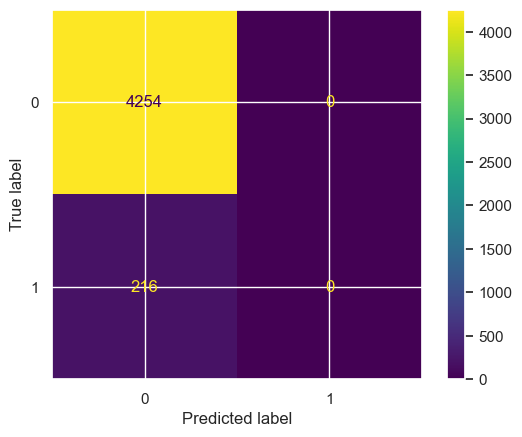

In [53]:
#Threshold = 0.5
metrics.ConfusionMatrixDisplay.from_estimator(clf_baseline, X_test, y_test)


Model metrics:
  Precision: 0.0
  Recall: 0.0
  F1-score: 0.0
len f1score: 2
len Thresholds: 1
index: 0
Optimal values:
  threshold: 0.0
  precision: 0.04832214765100671
  recall: 1.0
  F1-score: 0.09218950064020486


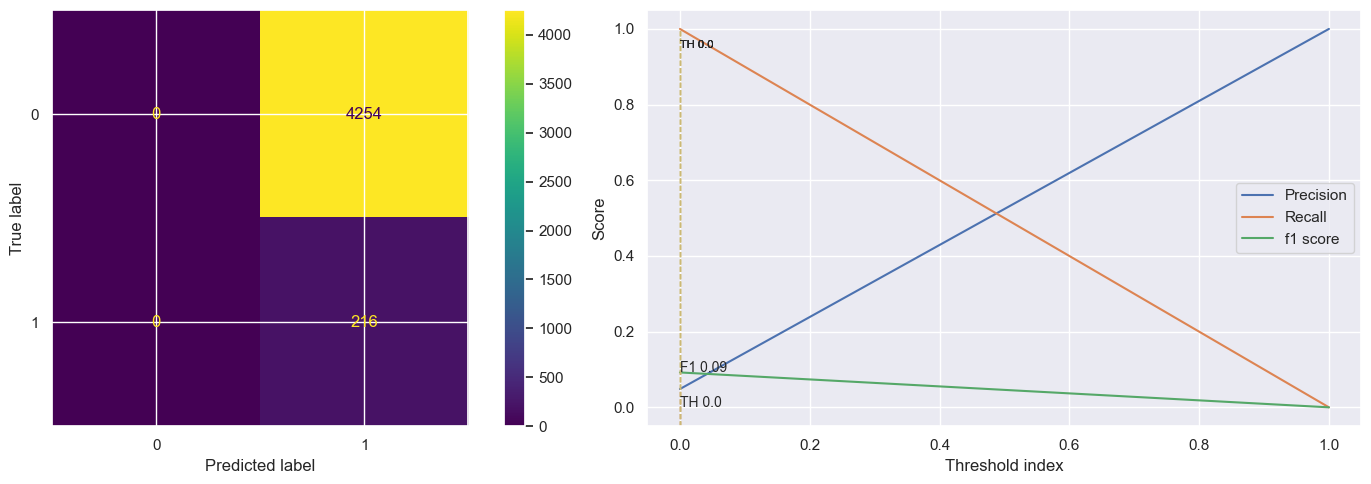

In [54]:
from time import time

def print_metrics(estimator, X, y_true):
    """
    Prints the precision, recall, and F1-score of a model.
    
    Parameters
    ----------
    estimator : sklearn estimator
        The estimator to use for prediction.
    X : numpy array
        The data to predict on.
    y_true : numpy array
        The true labels for the data.
    
    Returns
    -------
    None    
    """    
    y_pred = estimator.predict(X)
    precision, recall, f1score, _ = metrics.precision_recall_fscore_support(y_true, y_pred, average='binary')
    print("Model metrics:")
    print("  Precision:", precision)
    print("  Recall:",recall)
    print("  F1-score:",f1score)
    

def optimal_values(estimator, X, y_true, print_values=False, plot_charts=False):
    """
    This function takes a model, X and y_true as input and returns the optimal threshold, f1score, precision and recall.
    
    Parameters
    ----------
    estimator : sklearn model
        The model to be used for prediction.
    X : numpy array
        The input data.
    y_true : numpy array
        The true labels.
    print_values : bool, optional
        Whether to print the optimal values. The default is False.
    plot_charts : bool, optional
        Whether to plot the optimal confusion matrix and precision vs recall chart. The default is False.
    
    Returns
    -------
    y_pred_proba : numpy array
        The predicted probabilities for positive class.
    threshold_opt : float
        The optimal threshold.
    f1score_opt : float
        The optimal f1score.
    precision_opt : float
        The optimal precision score.
    recall_opt : float
        The optimal recall score.
    thresholds : numpy array
        The thresholds.
    
    """

    y_pred_proba = estimator.predict_proba(X)[:,1] # predictions probability for positive class

    
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred_proba)
    
    
#      # precision, recall manual calculations
#     y = np.array(y_true).reshape((-1,1))
#     pred = (y_pred_proba>= thresholds.reshape((-1,1))).T

#     TP = np.sum(np.logical_and(y , pred ), axis=0)
#     FN = np.sum(np.logical_and(y , np.logical_not(pred)), axis=0)
#     FP = np.sum( np.logical_and(np.logical_not(y) , pred), axis=0)
#     recall = np.append((TP /(TP+FN)), 0)
#     precision = np.append((TP /(TP+FP)), 1)
    
#     print("TP",TP, "FN",FN, "FP", FP,"recall", recall,"precision",precision)
    


    f1score = 2*(precision*recall)/(precision+recall)
    index = np.nanargmax(f1score)
    
    # print("Precision:", precision)
    # print("Recall:", len(recall))    
    # print("f1score:", f1score)
    print("len f1score:", len(f1score))
    print("len Thresholds:", len(thresholds))
    print("index:", index)
    threshold_opt = thresholds[index]
    f1score_opt = f1score[index]
    precision_opt = precision[index]
    recall_opt = recall[index]
        
    if print_values:
        print("Optimal values:")
        print("  threshold:", threshold_opt)        
        print("  precision:", precision_opt)
        print("  recall:", recall_opt)
        print("  F1-score:", f1score_opt)
    
    if plot_charts:
        fig, (ax0, ax1) = plt.subplots(ncols=2, layout="tight", figsize=(15,5))
        y_pred = y_pred_proba >= threshold_opt
        metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax0)
        sns.lineplot(x=range(len(precision)), y=precision, label="Precision", ax=ax1)
        sns.lineplot(x=range(len(recall)), y=recall, label="Recall", ax=ax1)
        ax= sns.lineplot(x=range(len(f1score)), y=f1score, label="f1 score", ax=ax1)
        text_annot = f"TH {np.round(threshold_opt,3)}"
        ax.annotate(text_annot, (index, 0), size=10)
        text_annot = f"F1 {np.round(f1score_opt,2)}"
        ax.annotate(text_annot, (index, f1score_opt), size=10)
        xlim0, xlim1 = ax.get_xlim()        
        ylim0, ylim1= ax.get_ylim()
        x_point = index/xlim1
        y_point = f1score_opt/ylim1
        ax.axhline(y=f1score_opt, xmax=x_point,linewidth=1, color='r', alpha=0.7,ls="--")
        ax.axvline(x=index, ymax=y_point,linewidth=1, color='r', alpha=0.7,ls="--")
        ax.set_xlabel("Threshold index")
        ax.set_ylabel("Score")
        # ax.set_xlim(-10,len(f1score)+10 )
        minor_tick = np.arange(0, len(f1score), 100)
        ax.set_xticks(minor_tick, minor=True)
        ax.grid(visible=True, which='major', axis="x")
        ax.grid(visible=True, which='minor',axis="x", alpha=0.4)
#         ax.grid(which='minor', alpha=1)
        
        
        for i in np.linspace(0, index, 6, dtype=int)[1:-1]:
            recall_value = recall[i]
            threshold_value = thresholds[i]
            y_point = recall_value/ylim1
            ax.axvline(x=i, ymax=y_point,linewidth=1, color='y', alpha=0.8,ls="--" )
            text_annot = f"TH {np.round(threshold_value,3)}"
            ax.annotate(text_annot, (i, recall_value-0.05), size=8)
            
    
    return y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds

def plot_recall_precision_threshold(y_true, y_pred_proba, threshold_index):
    """
    This function takes y_true, y_pred_proba and a threshold_index as input, prints and make charts for precision, recall and f1 score with specific threshold.
    
    Parameters
    ----------    
    y_true : numpy array
        The true labels.
    y_pred_proba : numpy array
        The probabilities of predictions
    threshold_index : int
        Index of the threshold list 
     
    """


    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred_proba)

    f1score = 2*(precision*recall)/(precision+recall)
    index = threshold_index
    
    threshold_opt = thresholds[index]
    f1score_opt = f1score[index]
    precision_opt = precision[index]
    recall_opt = recall[index]
        

    print("Optimal values:")
    print("  threshold:", threshold_opt)        
    print("  precision:", precision_opt)
    print("  recall:", recall_opt)
    print("  F1-score:", f1score_opt)

    fig, (ax0, ax1) = plt.subplots(ncols=2, layout="tight", figsize=(15,5))
    y_pred = y_pred_proba >= threshold_opt
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax0)
    sns.lineplot(x=range(len(precision)), y=precision, label="Precision", ax=ax1)
    sns.lineplot(x=range(len(recall)), y=recall, label="Recall", ax=ax1)
    ax= sns.lineplot(x=range(len(f1score)), y=f1score, label="f1 score", ax=ax1)
    text_annot = f"TH {np.round(threshold_opt,3)}"
    ax.annotate(text_annot, (index, 0), size=10)
    text_annot = f"F1 {np.round(f1score_opt,2)}"
    ax.annotate(text_annot, (index, f1score_opt), size=10)
    text_annot = f"Recall {np.round(recall_opt,3)}"
    ax.annotate(text_annot, (index, recall_opt), size=10)
    xlim0, xlim1 = ax.get_xlim()        
    ylim0, ylim1= ax.get_ylim()
    x_point = index/xlim1
    y_point = recall_opt/ylim1
    ax.axhline(y=f1score_opt, xmax=x_point,linewidth=1, color='r', alpha=0.7,ls="--")
    ax.axhline(y=recall_opt, xmax=x_point,linewidth=1, color='r', alpha=0.7,ls="--")
    ax.axvline(x=index, ymax=y_point,linewidth=1, color='r', alpha=0.7,ls="--")
    ax.set_xlabel("Threshold index")
    ax.set_ylabel("Score")
    # ax.set_xlim(-10,len(f1score)+10 )
    minor_tick = np.arange(0, len(f1score), 100)
    ax.set_xticks(minor_tick, minor=True)
    ax.grid(visible=True, which='major', axis="x")
    ax.grid(visible=True, which='minor',axis="x", alpha=0.4)


print_metrics(clf_baseline, X_test, y_test)

y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt,thresholds = optimal_values(clf_baseline, X_test, y_test, print_values = True,plot_charts=True)





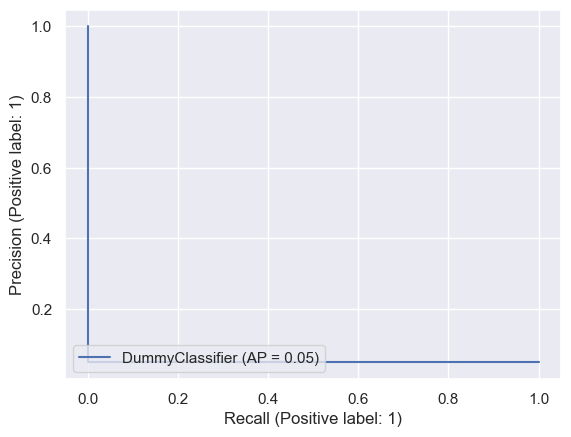

In [55]:
# Precision vs recall for each threshold
metrics.PrecisionRecallDisplay.from_estimator(clf_baseline, X_test, y_test)


## LogisticRegression

Now, we'll fit a basic Logistic Regression model to our data, to see that it manages to learn anything. We're not trying to optimize it yet, just see that it successfully learns something useful, and that our preparation of the data helped.

In [56]:
clf_logreg = LogisticRegression(random_state = RANDOM_SEED)
clf_logreg.fit(X_train, y_train)


LogisticRegression(random_state=42)

### Evaluation numeric features model

In [57]:
print_metrics(clf_logreg, X_test, y_test)

Model metrics:
  Precision: 0.0
  Recall: 0.0
  F1-score: 0.0


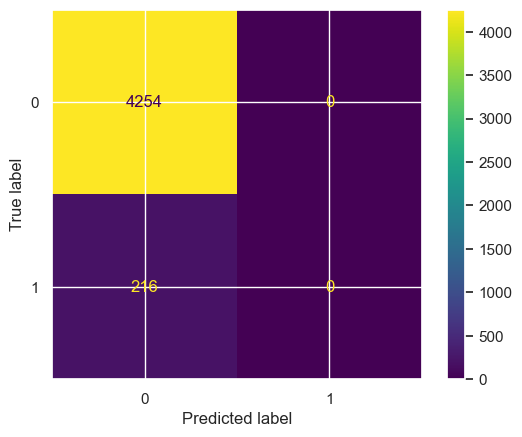

In [58]:
#Threshold = 0.5
metrics.ConfusionMatrixDisplay.from_estimator(clf_logreg, X_test, y_test)


It looks like the model did not learn nothing, lets calculate the best threshold and inspect again the confusion matrix.
- Threshold $\approx{0.20}$
- Recall $\approx{0.23}$
- Precision $\approx{0.42}$
- F1-score $\approx{0.29}$

Recall is still way to much low, only $\approx$23% of the true fraudulent job posts are predicted as fraudulent, Precision is a little better but still to low and as consequence F1-score is also to low.

In [159]:


y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds = optimal_values(clf_logreg, X_test, y_test, print_values = True,plot_charts=True)





len f1score: 4163
len Thresholds: 4162
index: 3934
Optimal values:
  threshold: 0.181982228216882
  precision: 0.2795275590551181
  recall: 0.3287037037037037
  F1-score: 0.30212765957446813


Optimal values:
  threshold: 0.039148701546798184
  precision: 0.14527363184079603
  recall: 0.6759259259259259
  F1-score: 0.23914823914823916


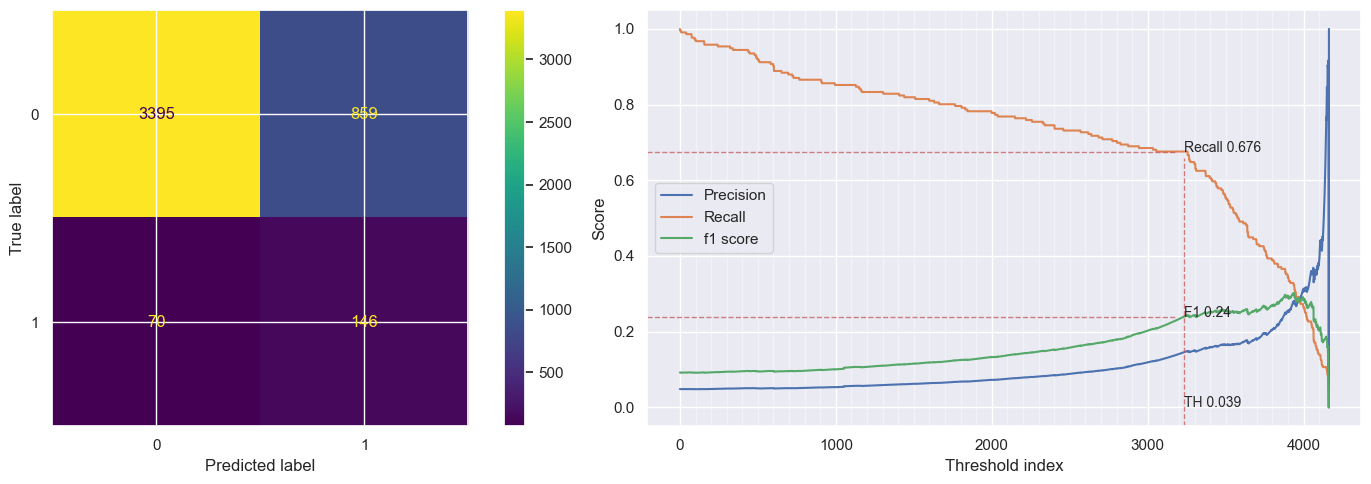

In [160]:
plot_recall_precision_threshold(y_test, y_pred_proba, threshold_index=3230) 


Text(0.34870370370370374, 0.2795275590551181, 'Threshold = 0.18\nf1-score = 0.3')

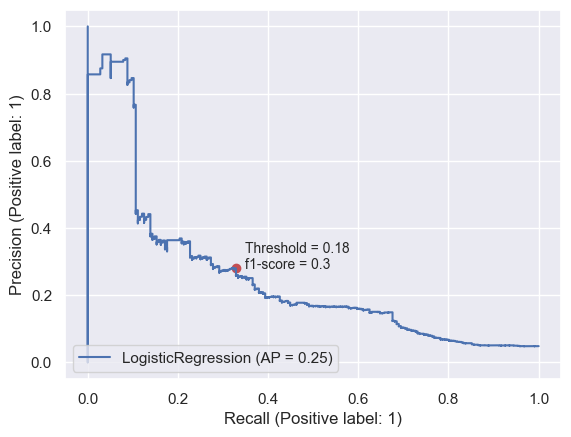

In [136]:
metrics.PrecisionRecallDisplay.from_estimator(clf_logreg , X_test, y_test) # AP = average precision
plt.scatter(recall_opt, precision_opt, color="r")
text_annot = f"Threshold = {np.round(threshold_opt,2)}\nf1-score = {np.round(f1score_opt,2)}"
plt.annotate(text_annot, (recall_opt+0.02, precision_opt), size=10)

Using only the numeric features we can see that the Logistic Regression model achieves an average precision of 0.26, and we can see that he did really learn useful information from the data, but only when the threshold was moved.

We can also look at the learned feature importances to understand what our model is looking for:

<AxesSubplot:>

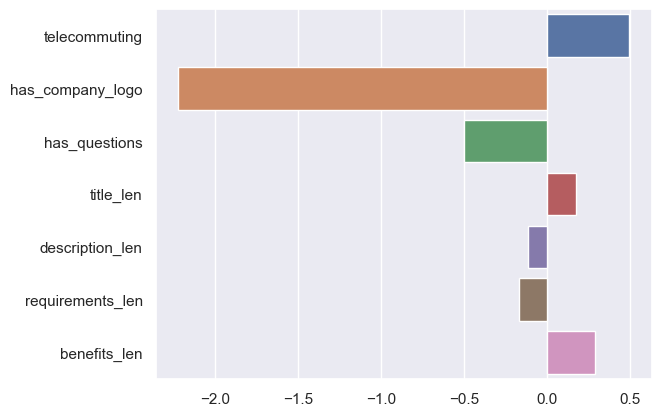

In [84]:
sns.barplot(y=NUM_COLS, x=clf_logreg.coef_[0])

Recall that this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. 
The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

`has_company_logo` have the most importance in the model predicting the class `0` while `has_question` have some importance.

`telecommuting` have the most importance predicting the class `1`. 

`title_len` have positive importance, `description_len` and `requirements_len` have negative importance but almost no importance when predicting the class.

This is aligned with our EDA on numeric columns where we checked the conditional probability and the kernel density of text length.

### NLP - Textual Features

So, at this point we have a sense for our data, have found a good way to scale and normalize our *numeric* features, and have trained a very basic classifier on it.

Introduction to NLP, Natural Language Processing is a branch of Artificial Intelligence that analyzes, processes, and efficiently retrieves information text data.

The next phase would be to see what happens when we take advantage of using techniques from NLP in our textual features  - `title`, `company_profile`, `description`, `requirements`. We'll use *only* the textual features to simplify things and isolate the effects.

To start simple, we'll unify only `title` and `description` into one big textual column. Latter we will try another approach unifying all textual columns.

In [85]:
train_text_col = train_df_norm["title"] +" "+ train_df_norm["description"] 
test_text_col = test_df_norm["title"] +" "+ test_df_norm["description"] 

To turn this text into numerical features that can be used as input to a ML model, we'll use [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with a sensible limit of vocabulary size (`max_features=25000`). It will split the text into tokens, and give each text in the data a numerical representation of the frequency of tokens in that text.

Note that special care is needed when handling [sparse matrices in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html), and the result returned from `TfidfVectorizer` is a sparse matrix. **If you ignore this special handling, expect to run into out-of-memory errors, unresponsiveness and crashes as the sparse matrix gets inflated.**

In [86]:
tfidf = TfidfVectorizer(max_features=25000)
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names())


**Interesting notes:**
* Since the English Longest word in a major dictionary is Pneumonoultramicroscopicsilicovolcanoconiosis (45 letters) ( Pneumoconiosis caused by inhalation of very fine silicate or quartz dust. ) and the second is Hippopotomonstrosesquippedaliophobia (36 letters) we will make a regex expression that will only consider alpha numeric words no longer than 35 letters. 
Source:https://irisreading.com/10-longest-words-in-the-english-language/
* We also will ignore words that start with a number


In [87]:
print("words with more than 36 letters:", [w for w in tfidf.get_feature_names() if len(w) >36][:10])

words with more than 36 letters: ['yijdnw4jujjilj17glxmbmfmqvbeix022dcqup8rsgcn4zyfax1c1nuxkpu1q66j']


In [179]:

PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN)
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()


In [180]:
print(train_tfidf_df.shape)
train_tfidf_df.sample(15, axis=1).head()

(13410, 25000)


,bow,incontinence,perfected,cm3,org,insert,announcer,creating,cios,centerpoint,subscribe,plankton,sqlare,created,solicitadas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, y_train)

LogisticRegression(random_state=42)

### Evaluating the textual model

Below, we can see that the new text-based model performs way better!

This is not surprising, as most information will be contained in the text content of each post.

Without adjusting the threshold we get a great precision but a bad recall, F1-score gets near 0.5.

Adjusting the threshold to $\approx$0.18 we get a better F1-score with a value of $\approx$0.57, raising our recall from $\approx$0.33 to $\approx$0.57, making this our best model.


In [182]:
print_metrics(clf_tfidf, X_tfidf_test, y_test)

Model metrics:
  Precision: 0.9824561403508771
  Recall: 0.25925925925925924
  F1-score: 0.41025641025641024


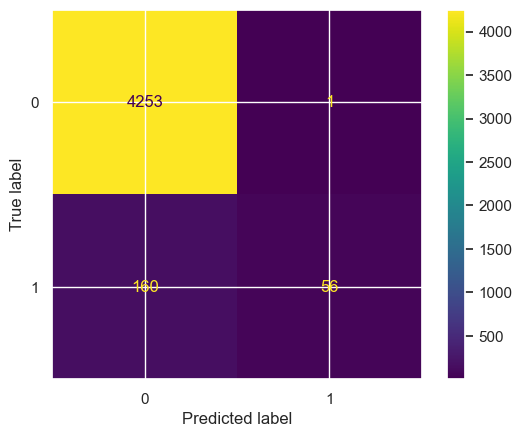

In [183]:
#Threshold = 0.5
metrics.ConfusionMatrixDisplay.from_estimator(clf_tfidf, X_tfidf_test, y_test)

len f1score: 4103
len Thresholds: 4102
index: 3925
Optimal values:
  threshold: 0.13387259086161724
  precision: 0.7028301886792453
  recall: 0.6898148148148148
  F1-score: 0.6962616822429907


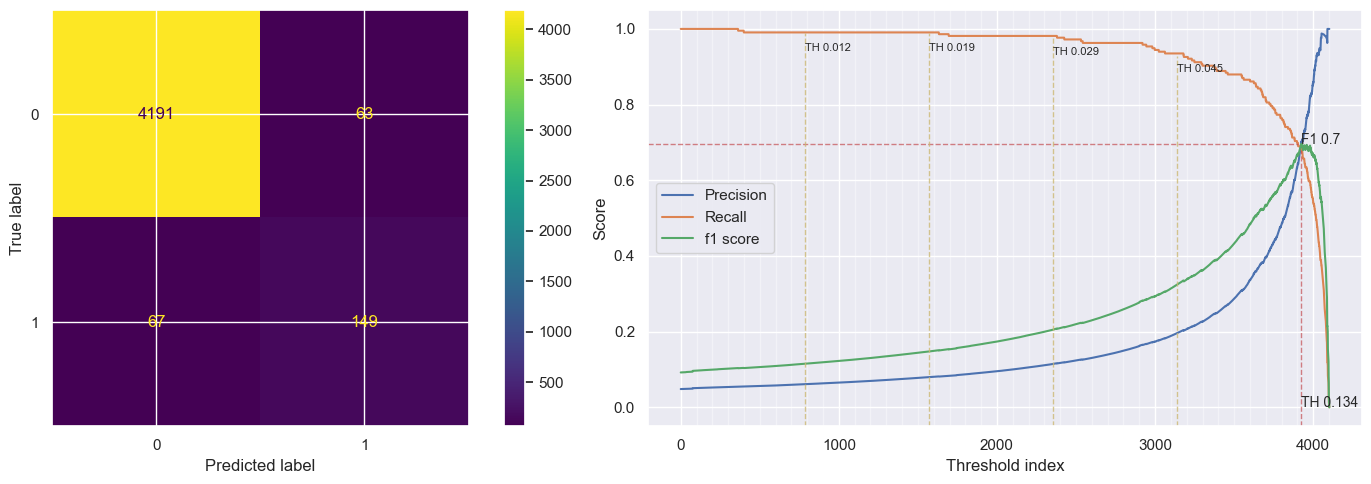

In [184]:
y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds  = optimal_values(clf_tfidf , X_tfidf_test, y_test, print_values = True, plot_charts=True)




Text(0.7098148148148148, 0.7028301886792453, 'Threshold = 0.13\nf1-score = 0.7')

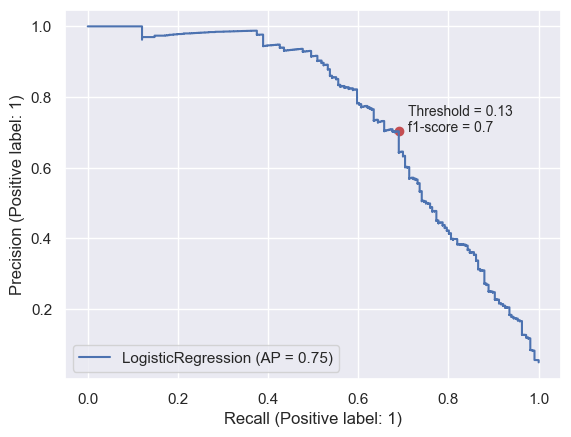

In [185]:
metrics.PrecisionRecallDisplay.from_estimator(clf_tfidf , X_tfidf_test, y_test) # AP = average precision
plt.scatter(recall_opt, precision_opt, color="r")
text_annot = f"Threshold = {np.round(threshold_opt,2)}\nf1-score = {np.round(f1score_opt,2)}"
plt.annotate(text_annot, (recall_opt+0.02, precision_opt), size=10)


Optimal values:
  threshold: 0.058807479385722436
  precision: 0.28700906344410876
  recall: 0.8796296296296297
  F1-score: 0.4328018223234624


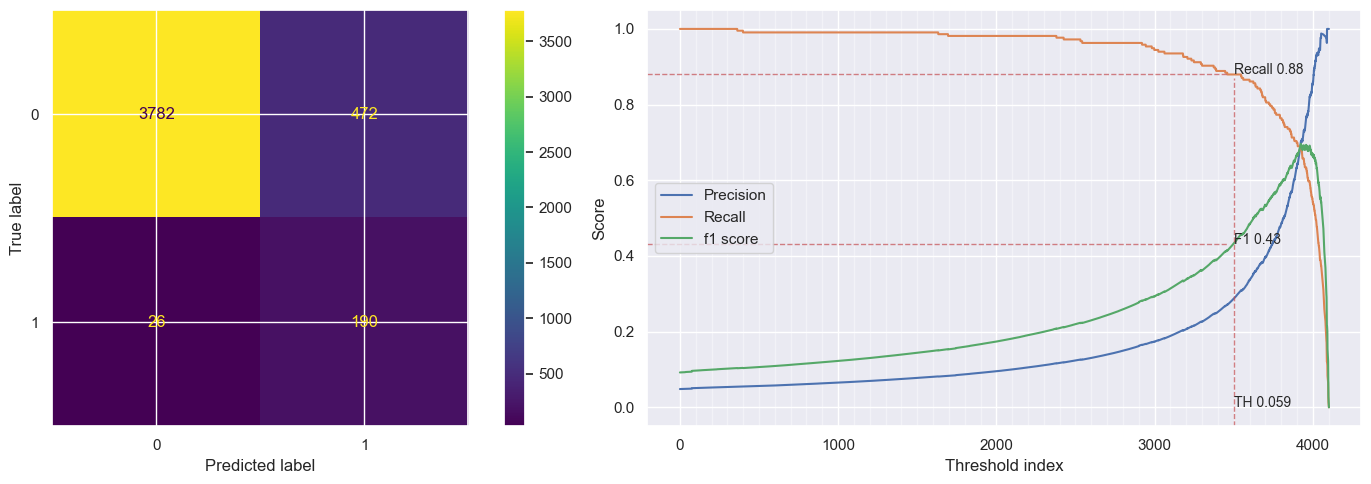

In [186]:
plot_recall_precision_threshold(y_test, y_pred_proba, threshold_index=3550) 


As a sanity check, it's a good idea to check what terms the textual model cares about when making its decision.

As we see below, it looks like our model learned some things, such as `aker` and `subsea` are terms that only shows in fraudulent job posts, so makes sense that they are *positive* predictors with high coefficients. Other curious term is the term 'our', it's a word that brings some engagement with the significance that something exists that is not the case in a fraudulent job post. 

Description example with term 'aker': Fining dining restaurant and lounge seeks EXPERIENCED and SERIOUS servers and bartenders to join the


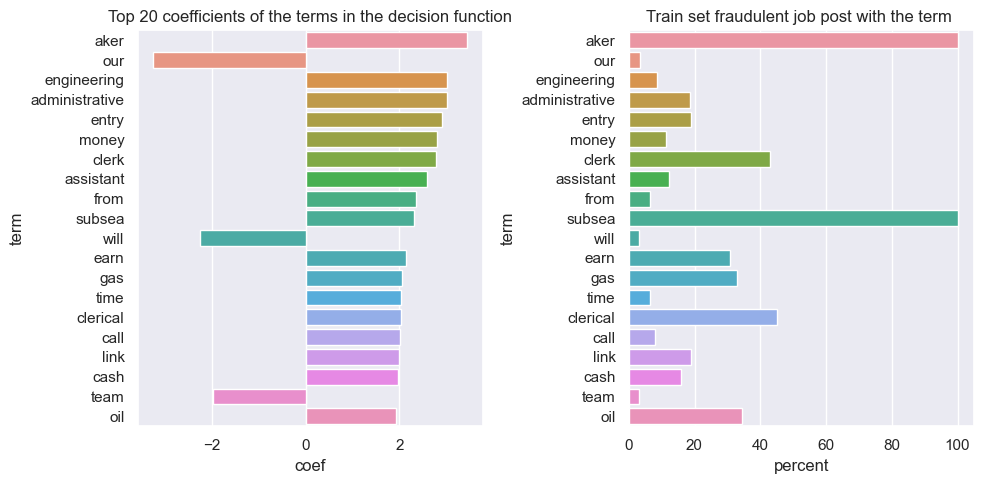

In [95]:
fig, (ax0, ax1) =  plt.subplots(ncols=2, layout='tight', figsize=(10,5))

print("Description example with term 'aker':", train_df_norm.loc[120,"description"][:100])

tfidf_coef_df = pd.DataFrame({'coef':clf_tfidf.coef_[0]})
tfidf_coef_df['term'] = tfidf.get_feature_names()
tfidf_coef_df['coef_abs'] = tfidf_coef_df['coef'].abs()
tfidf_coef_df = tfidf_coef_df.sort_values('coef_abs', ascending=False)
sns.barplot(y='term', x='coef', data=tfidf_coef_df[:20], ax=ax0).set(title="Top 20 coefficients of the terms in the decision function")


dict_fraudulent_terms = {col:  y_train[train_tfidf_df[col]!=0].mul(100).values.mean().round(2) for col in tfidf_coef_df["term"][:20]}
df_fraudulent_terms = pd.DataFrame(dict_fraudulent_terms.values(), index=dict_fraudulent_terms.keys(), columns=["percent"])

sns.barplot( y=df_fraudulent_terms.index, x=df_fraudulent_terms["percent"], ax=ax1).set(title="Train set fraudulent job post with the term ", xlabel="percent", ylabel="term");


### Ngrams 
An N-gram means a sequence of N words. So for example, “Medium blog” is a 2-gram (a bigram), “A Medium blog post” is a 4-gram, and “Write on Medium” is a 3-gram (trigram).

By including unigrams, bigrams or trigrams in the model, is more likely to capture important information that appears as multiple tokens in the text--for example, "account management".

As we can see we can achive a better results combining unigrams, bigrams and trigrams, having $\approx$4% increase of optimal F1 score from previous model.

Bigrams

vectorize testing done in 23.427s 
len f1score: 4068
len Thresholds: 4067
index: 3885
Optimal values:
  threshold: 0.12058893351890738
  precision: 0.7188940092165899
  recall: 0.7222222222222222
  F1-score: 0.7205542725173208


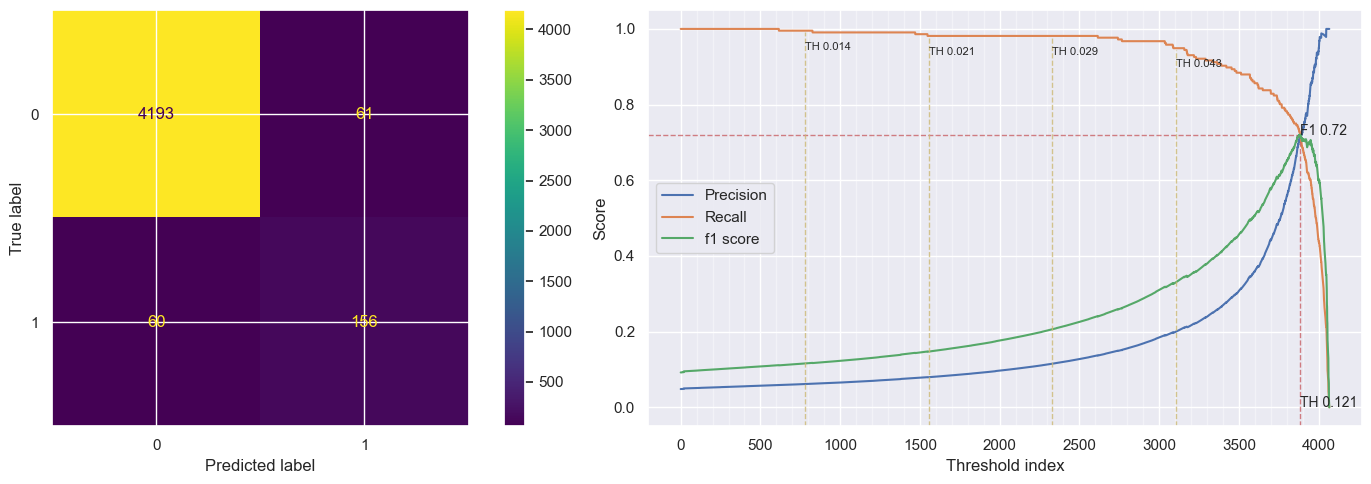

In [168]:
from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,2))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, y_train)

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")


y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds  = optimal_values(clf_tfidf , X_tfidf_test, y_test, print_values = True, plot_charts=True)


Optimal values:
  threshold: 0.05890497474764306
  precision: 0.3075684380032206
  recall: 0.8842592592592593
  F1-score: 0.4563918757467144


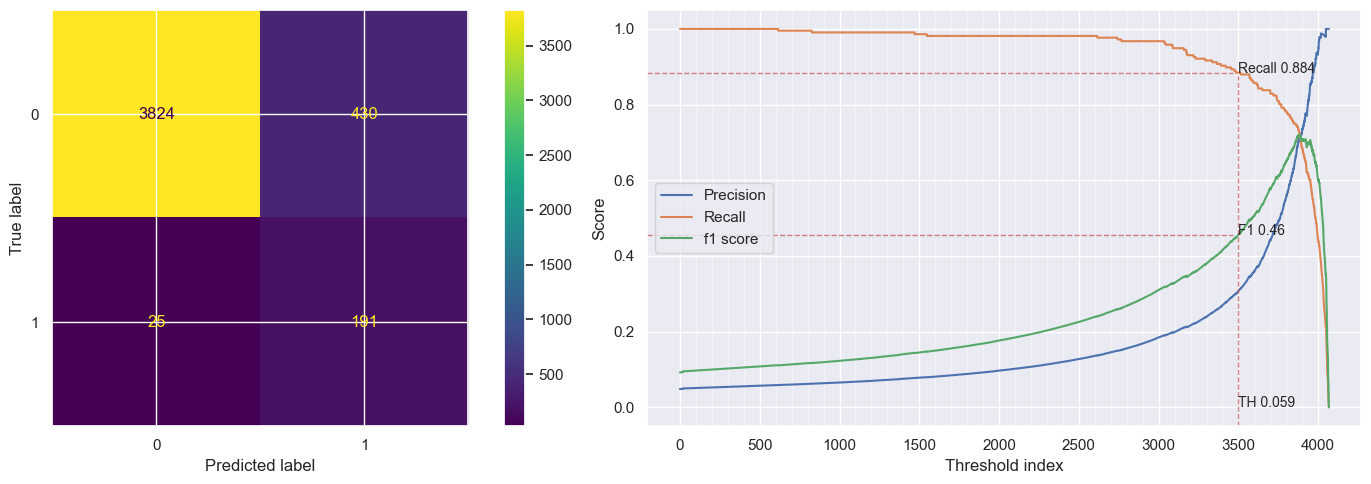

In [169]:
plot_recall_precision_threshold(y_test, y_pred_proba, threshold_index=3550) 

Trigrams

vectorize testing done in 26.987s 
len f1score: 4064
len Thresholds: 4063
index: 3885
Optimal values:
  threshold: 0.12639580553633678
  precision: 0.7417840375586855
  recall: 0.7314814814814815
  F1-score: 0.7365967365967367


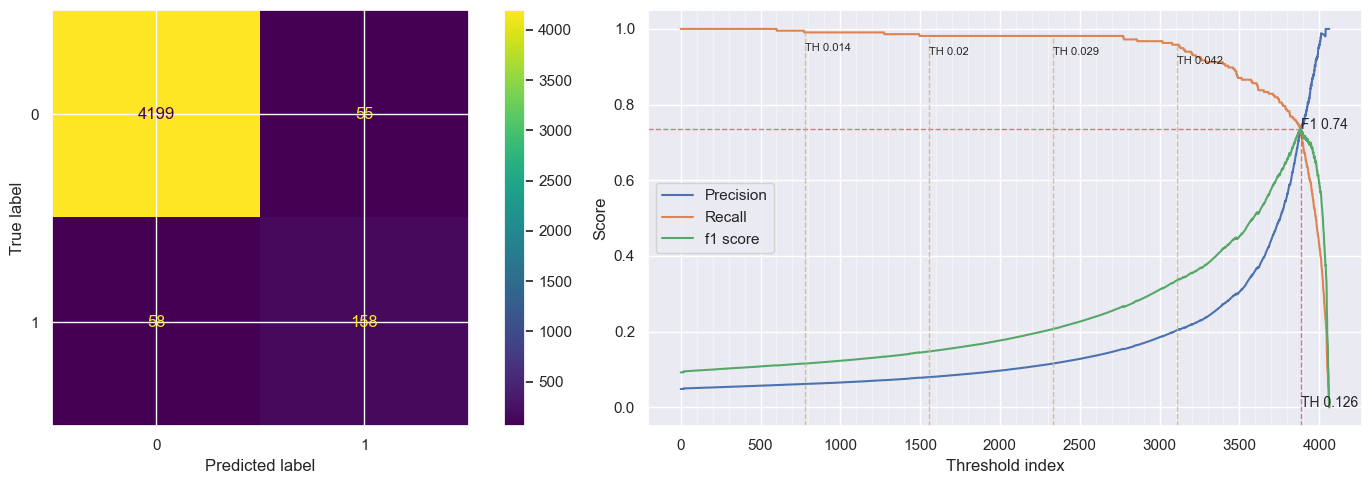

In [187]:
from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,3))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, y_train)

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")

y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds  = optimal_values(clf_tfidf , X_tfidf_test, y_test, print_values = True, plot_charts=True)


Optimal values:
  threshold: 0.05972757325477423
  precision: 0.3047001620745543
  recall: 0.8703703703703703
  F1-score: 0.4513805522208883


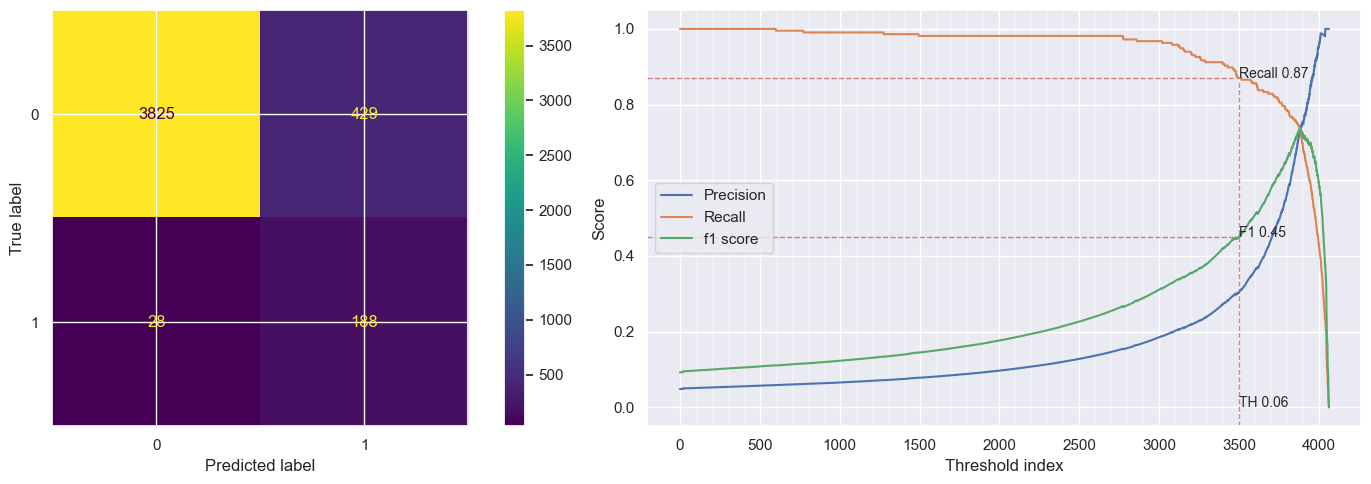

In [189]:
plot_recall_precision_threshold(y_test, y_pred_proba, threshold_index=3550) 

Let's check some unigram, bigram and trigram words:

In [98]:
print(train_tfidf_df.shape)
train_tfidf_df.sample(15, axis=1, random_state=42).head()

(13410, 25000)


,development skills,with our public,full,mobile business,need your help,electrical maintenance,could the,making real,automated test,friday,the machines assemble,background investigation,design team,skills are must,and utilize
0,0.0,0.0,0.016837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lemmatization

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.

Examples of lemmatization:
- rocks : rock
- corpora : corpus
- better : good

This did not improved our metrics. This idea will be abandoned.

In [99]:
# import these modules
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to /home/repl/nltk_data...
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...


vectorize testing done in 37.440s 
len f1score: 4065
len Thresholds: 4064
index: 3921
Optimal values:
  threshold: 0.15177814657321378
  precision: 0.8033707865168539
  recall: 0.6620370370370371
  F1-score: 0.7258883248730964


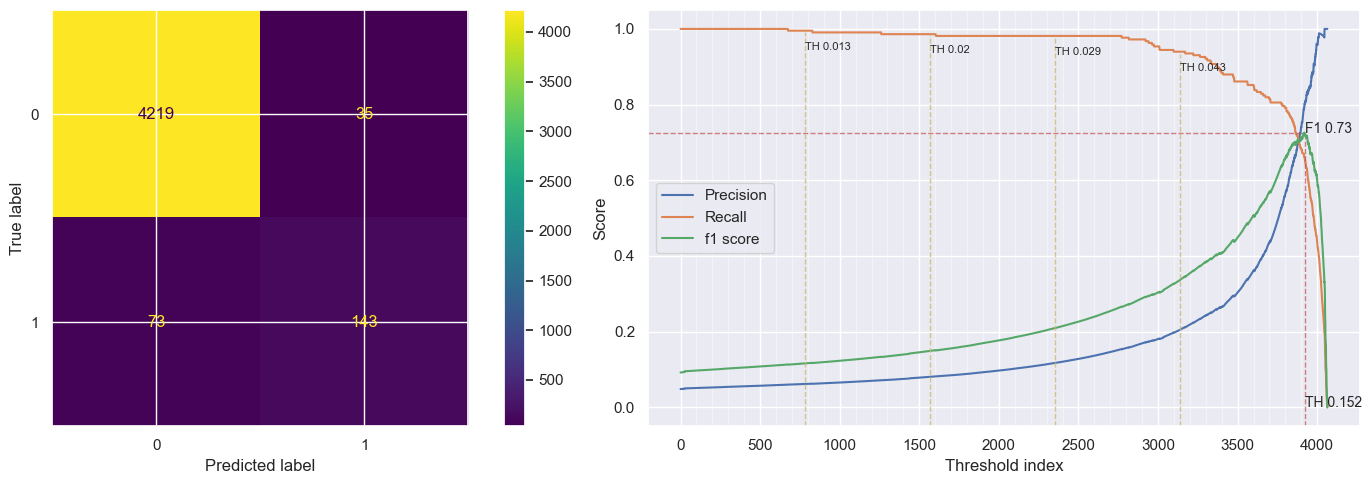

In [190]:
from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36

wnl = WordNetLemmatizer()


def lemmatize_words(text):
    words = text.split()    
    words = [wnl.lemmatize(word) for word in words] 
    return ' '.join(words)

train_text_lem_col = train_text_col.apply(lemmatize_words)
test_text_lem_col = test_text_col.apply(lemmatize_words)


tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,3))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_lem_col), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_lem_col), columns=tfidf.get_feature_names())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, y_train)

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")

y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds  = optimal_values(clf_tfidf , X_tfidf_test, y_test, print_values = True, plot_charts=True)








Optimal values:
  threshold: 0.05915158317362501
  precision: 0.3034257748776509
  recall: 0.8611111111111112
  F1-score: 0.4487334137515079


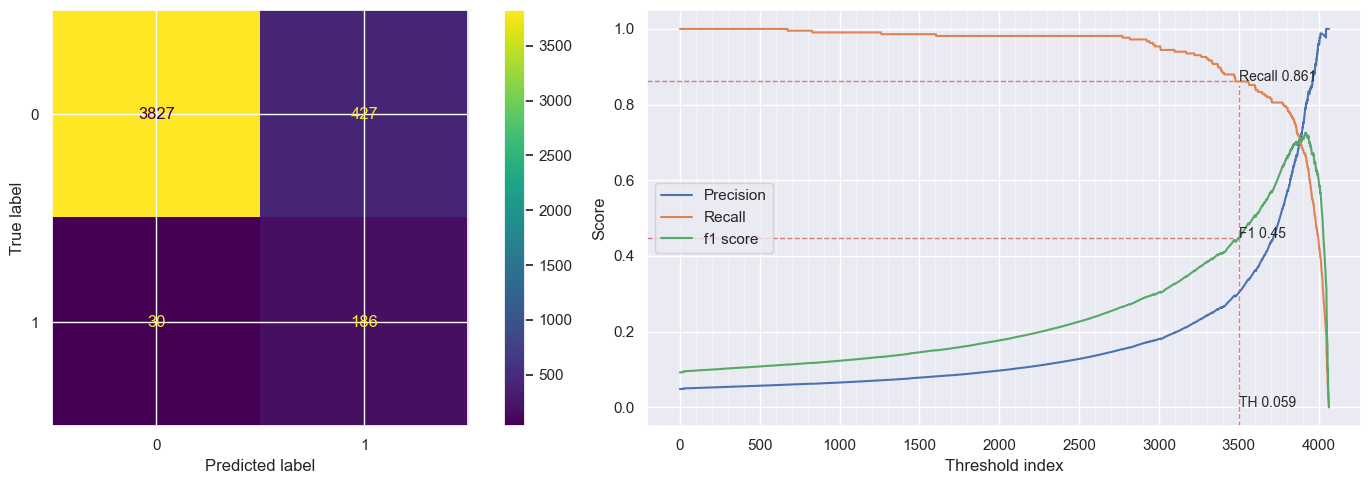

In [192]:
plot_recall_precision_threshold(y_test, y_pred_proba, threshold_index=3500) 

### Oversampling

Perform over-sampling using Adaptive Synthetic Sampling Approach for Imbalanced Learning.
Oversampling the train dataset did not improved.

In [83]:
from imblearn.over_sampling import ADASYN

from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,3))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
# Apply the random over-sampling
ada = ADASYN(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = ada.fit_resample(X_tfidf_train, y_train)
print("Before oversampling X train shape:",X_tfidf_train.shape, np.mean(y_train) )
print("After oversampling X train shape:",X_train_resampled.shape, np.mean(y_train_resampled) )

X_tfidf_test = test_tfidf_df.sparse.to_coo()

# X_test_resampled, y_test_resampled = ada.fit_resample(X_tfidf_test, y_test)
# print("Before oversampling X test shape:",X_tfidf_test.shape, np.mean(y_test) )
# print("After oversampling X test shape:",X_test_resampled.shape, np.mean(y_test_resampled) )



clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_train_resampled, y_train_resampled)

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")




vectorize testing done in 44.012s 


Model metrics:
  Precision: 0.6452830188679245
  Recall: 0.7916666666666666
  F1-score: 0.7110187110187111


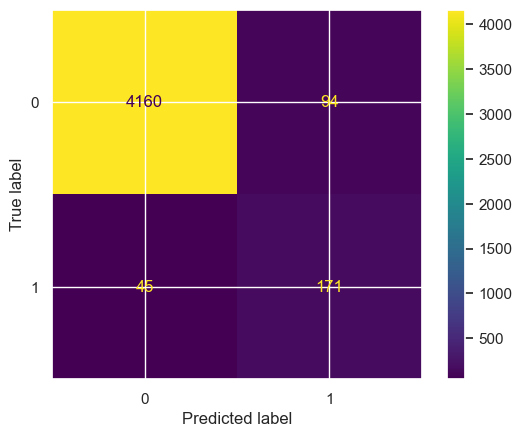

In [84]:
print_metrics(clf_tfidf, X_tfidf_test, y_test)

#Threshold = 0.5
metrics.ConfusionMatrixDisplay.from_estimator(clf_tfidf, X_tfidf_test, y_test)

len f1score: 4064
len Thresholds: 4063
index: 3920
Optimal values:
  threshold: 0.7137291856041483
  precision: 0.8426966292134831
  recall: 0.6944444444444444
  F1-score: 0.7614213197969543


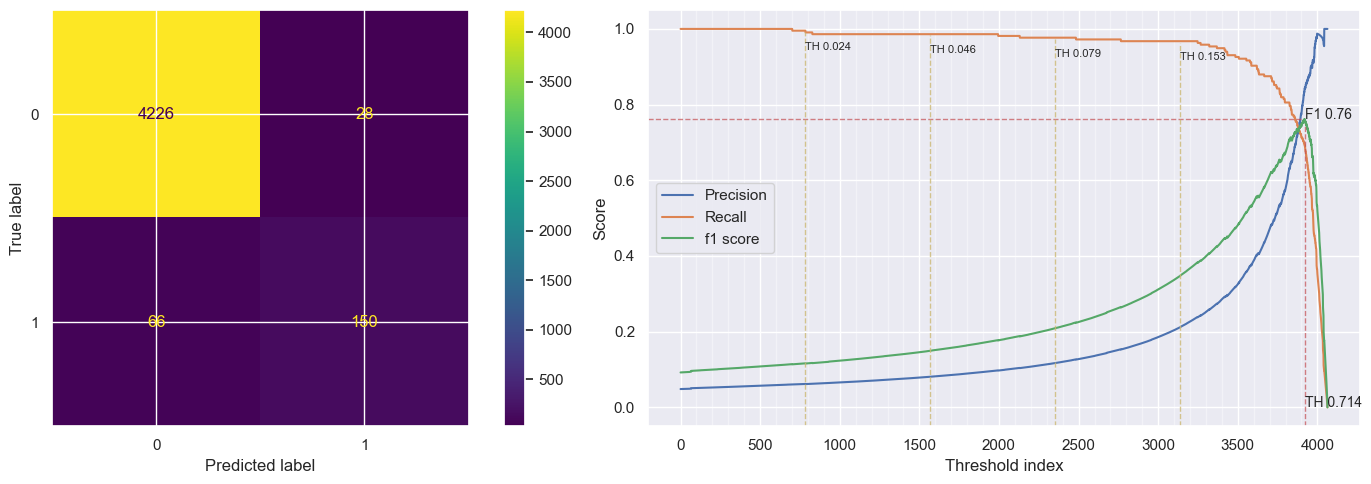

In [85]:
y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds  = optimal_values(clf_tfidf , X_tfidf_test, y_test, print_values = True, plot_charts=True)


Optimal values:
  threshold: 0.24141954275256272
  precision: 0.3252032520325203
  recall: 0.9259259259259259
  F1-score: 0.4813477737665463


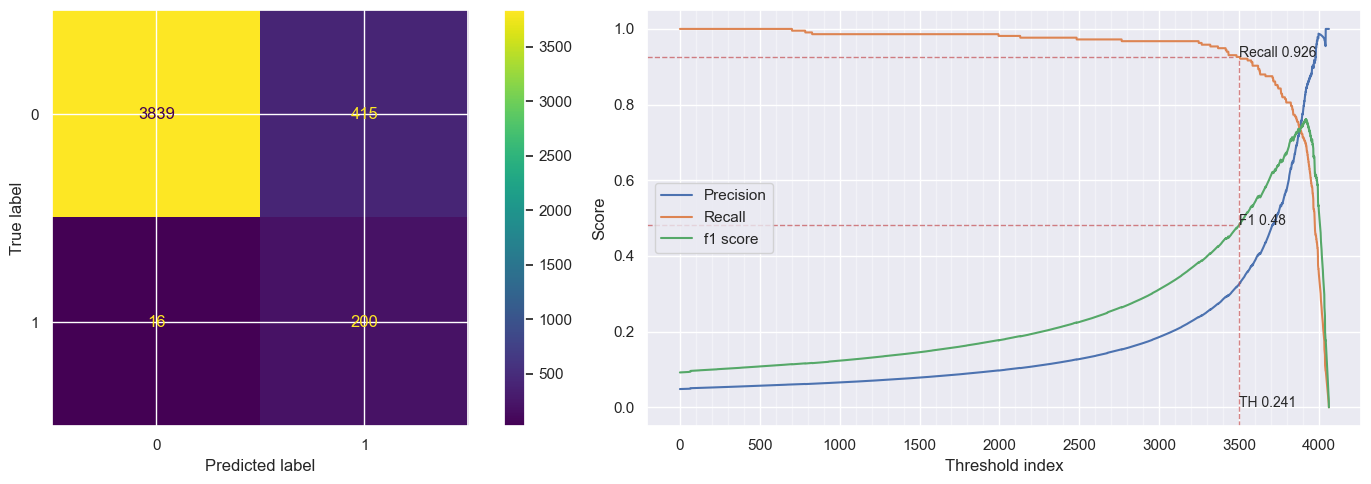

In [86]:
plot_recall_precision_threshold(y_test, y_pred_proba, threshold_index=3500) 

## Undersampling

In [87]:


from imblearn.under_sampling import RandomUnderSampler

from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,3))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
# Apply the random over-sampling
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = rus.fit_resample(X_tfidf_train, y_train)
print("Before oversampling X train shape:",X_tfidf_train.shape, np.mean(y_train) )
print("After oversampling X train shape:",X_train_resampled.shape, np.mean(y_train_resampled) )

X_tfidf_test = test_tfidf_df.sparse.to_coo()

# X_test_resampled, y_test_resampled = ada.fit_resample(X_tfidf_test, y_test)
# print("Before oversampling X test shape:",X_tfidf_test.shape, np.mean(y_test) )
# print("After oversampling X test shape:",X_test_resampled.shape, np.mean(y_test_resampled) )



clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_train_resampled, y_train_resampled)

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")





Before oversampling X train shape: (13410, 25000) fraudulent    0.048471
dtype: float64
After oversampling X train shape: (1300, 25000) fraudulent    0.5
dtype: float64
vectorize testing done in 22.609s 


Model metrics:
  Precision: 0.31732418524871353
  Recall: 0.8564814814814815
  F1-score: 0.46307884856070086


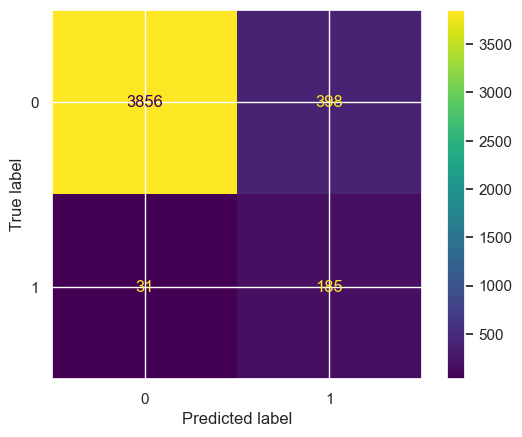

In [88]:
print_metrics(clf_tfidf, X_tfidf_test, y_test)

#Threshold = 0.5
metrics.ConfusionMatrixDisplay.from_estimator(clf_tfidf, X_tfidf_test, y_test)

len f1score: 4064
len Thresholds: 4063
index: 3911
Optimal values:
  threshold: 0.6367729788902039
  precision: 0.7219251336898396
  recall: 0.625
  F1-score: 0.6699751861042184


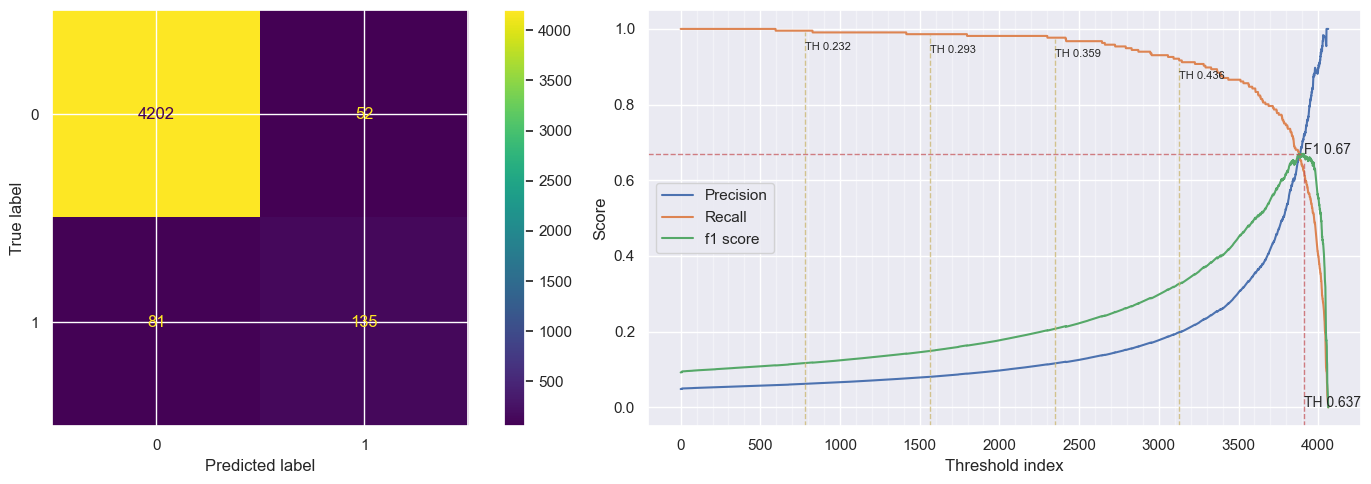

In [203]:
y_pred_proba, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds  = optimal_values(clf_tfidf , X_tfidf_test, y_test, print_values = True, plot_charts=True)

Optimal values:
  threshold: 0.49344010574568953
  precision: 0.30357142857142855
  recall: 0.8657407407407407
  F1-score: 0.4495192307692308


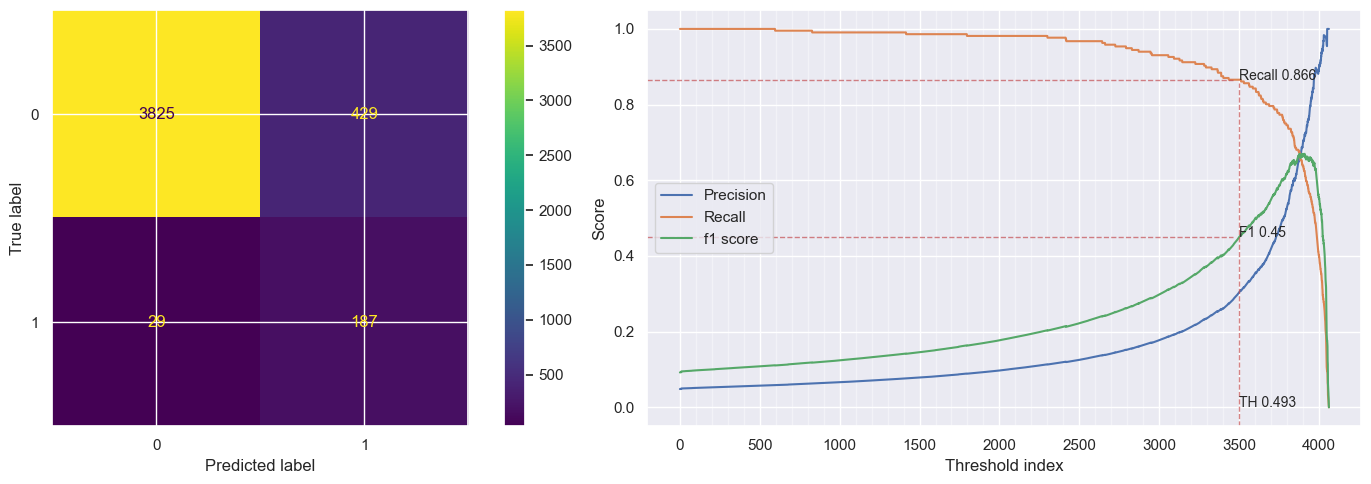

In [209]:
plot_recall_precision_threshold(y_test, y_pred_proba, threshold_index=3500) 

## Various Models

In [128]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state = RANDOM_SEED),
        'metrics': {}
    },    
    'Linear SVM': {
        'model': SVC(kernel='linear',probability=True,random_state = RANDOM_SEED),
        'metrics': {}
    },
    'SVM': {
        'model': SVC(probability=True,random_state = RANDOM_SEED),
        'metrics': {}
    }, 
    'K-nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'metrics': {}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'Neural Network': {
        'model': MLPClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    }
}




In [129]:
from time import time
for k, v in classifiers.items():
    t0 = time()    
    model = v["model"]
    model.fit(X_tfidf_train, y_train)
    duration_test = time() - t0
    y_pred = model.predict(X_tfidf_test)
    precision, recall, f1score, _ = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')
    _, threshold_opt, f1score_opt, precision_opt, recall_opt, thresholds  = optimal_values(model , X_tfidf_test, y_test, print_values = True )
    v["metrics"] = {"precision":precision, "recall":recall, "f1":f1score, "threshold":threshold_opt, "precision_opt":precision_opt, "recall_opt":recall_opt, "f1_opt": f1score_opt, "exec_time":duration_test}    
    print(f"Model done in {duration_test:.3f}s\n")
    

df_metrics = pd.DataFrame([{"model":k, **{ mk:mv  for mk, mv in v["metrics"].items()  }} for k, v in classifiers.items()   ])


    

len f1score: 4064
len Thresholds: 4063
index: 3885
Optimal values:
  threshold: 0.12639580553633678
  precision: 0.7417840375586855
  recall: 0.7314814814814815
  F1-score: 0.7365967365967367
Model done in 8.773s

len f1score: 4063
len Thresholds: 4062
index: 3912
Optimal values:
  threshold: 0.2624794424305851
  precision: 0.8594594594594595
  recall: 0.7361111111111112
  F1-score: 0.7930174563591023
Model done in 208.511s



In [163]:
df_metrics = df_metrics.sort_values("f1_opt", ascending=False)


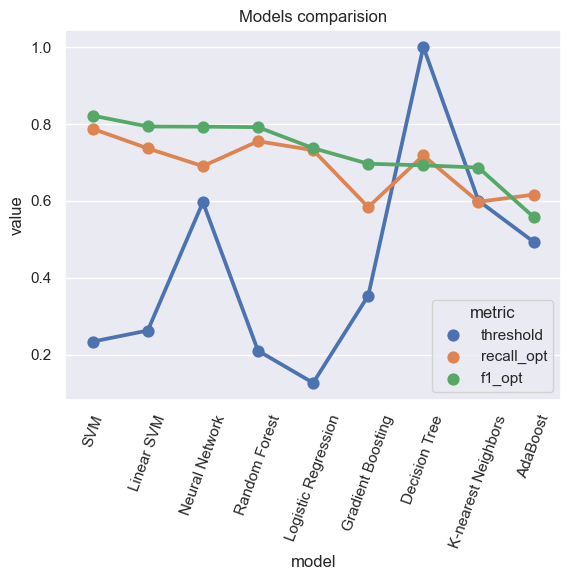

In [166]:
from pandas.api.types import CategoricalDtype

# fig, (ax0, ax1) = fig.suplots(ncols=2, figsize=(15,5), layout="tight")

df_metric_melt=pd.melt(df_metrics, id_vars=["model"],value_vars=["threshold","recall_opt","f1_opt"], var_name="metric",value_name="value" )



ax= sns.pointplot(data=df_metric_melt, x="model", y="value", hue="metric")
ax.set(title="Models comparision")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);
# plt.show();
# sns.barplot(data=df, x="model", y="recall_opt", ax=ax0).set(title=f"Optimal threshold F1 score")
# ax.set_legend(["F1 score", ""])
# sns.barplot(data=df, x="model", y="f1_opt", ax=ax1)

In [141]:
# fig, (ax0, ax1) = fig.suplots(ncols=2, figsize=(15,5), layout="tight")

df_metric_melt=pd.melt(df_metrics, id_vars=["model"],value_vars=["threshold","recall_opt","f1_opt"], var_name="metric",value_name="value" )
# df_metric_melt
sns.pointplot(data=df_metric_melt, x="model", y="value", hue="metric", ax=ax0)
plt.show();
# sns.barplot(data=df, x="model", y="recall_opt", ax=ax0).set(title=f"Optimal threshold F1 score")
# ax.set_legend(["F1 score", ""])
# sns.barplot(data=df, x="model", y="f1_opt", ax=ax1)


# Conclusion

When we apply the "threshold-moving" technique we can get better metrics results.

Using default hyperparameters RandomForest was the best model in the F1 score with 

To create more versions with new models I will leave this notebook and start a new DagsHub project and start to do some versioning to track experiments.

Checkout the project ->[here](https://dagshub.com/tiagopatriciosantos/Fake_job_postings)<-.


Some ideas:

- Hyperparameter tunning
- Using deeplearning networks from keras - RNN Recurrent Neural Networks , for example Bidirectional LSTM
- pyCaret - https://pycaret.gitbook.io/docs/